**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2025*

----

# Trabajo práctico entregable - parte 1

En esta notebook, vamos a cargar el conjunto de datos de [la compentencia Kaggle](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot) sobre estimación de precios de ventas de propiedades en Melbourne, Australia.

Utilizaremos el conjunto de datos reducido producido por [DanB](https://www.kaggle.com/dansbecker). Hemos subido una copia a un servidor de la Universidad Nacional de Córdoba para facilitar su acceso remoto.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd

import seaborn as sns
sns.set_context('talk')

from sqlalchemy import create_engine, text
import math

In [2]:
import plotly
plotly.__version__

'5.9.0'

## Ejercicio 1 SQL:

1. Crear una base de datos en SQLite utilizando la libreria [SQLalchemy](https://stackoverflow.com/questions/2268050/execute-sql-from-file-in-sqlalchemy).
https://docs.sqlalchemy.org/en/14/core/engines.html#sqlite

2. Ingestar los datos provistos en 'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv' en una tabla y el dataset generado en clase con datos de airbnb y sus precios por codigo postal en otra.

3. Validar tipos de columnas antes de guardar: df.to_sql() infiere tipos automáticamente, pero a veces los nombres de columnas como Date, Price o ID dan problemas si vienen con strings o valores nulos.

4. Implementar consultas en SQL que respondan con la siguiente información:

    - cantidad de registros totales por ciudad.
    - cantidad de registros totales por barrio y ciudad.
    - Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?
    - Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?
    - Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.

5. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL  para obtener un resultado similar a lo realizado con Pandas en clase.  



In [3]:
#######################################################
# Datos Melbourne por DanB
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

#######################################################
# Datos de la plataforma AirBnB en Melbourne 2018 por Tyler Xie
interesting_cols = [
  'neighborhood', 'city', 'price','bedrooms', 'property_type'
]

airbnb_df = pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv',usecols=interesting_cols)

#######################################################
# Datos generados en clase con datos de airbnb y sus precios por codigo postal
file_path = './airbnb_price_by_zipcode.csv'
airbnb_clase_df = pd.read_csv(file_path)

## **Correcciones / limpieza de datos para el dataframa melb**


In [4]:
#Tipos de variables en el dataframe melb
print(melb_df.dtypes)

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object


In [5]:
# Modificar las columnas con enteros--> Int64 acepta NaN
melb_df['Rooms']     = melb_df['Rooms'].astype('Int64')
melb_df['Bedroom2']  = melb_df['Bedroom2'].astype('Int64')
melb_df['Bathroom']  = melb_df['Bathroom'].astype('Int64')
melb_df['Car']       = melb_df['Car'].astype('Int64')

In [6]:
#Cantidad de NaN o NaT
for column in melb_df.columns:
    nan_count = melb_df[column].isna().sum()
    if nan_count > 0:
        print(f'Columna: "{column}" — NaN/NaT: {nan_count}')

Columna: "Car" — NaN/NaT: 62
Columna: "BuildingArea" — NaN/NaT: 6450
Columna: "YearBuilt" — NaN/NaT: 5375
Columna: "CouncilArea" — NaN/NaT: 1369


En este dataframe, Postcode no contiene NaN.

In [7]:
print(melb_df.dtypes)

Suburb            object
Address           object
Rooms              Int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2           Int64
Bathroom           Int64
Car                Int64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object


In [8]:
melb_df.head(5)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1,1,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1,0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2,0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2,1,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1,2,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


## **Correcciones / limpieza de datos para el dataframe airbnb_clase**

In [9]:
#Tipos de variables en el dataframe airbnb
print(airbnb_clase_df.dtypes)

zipcode                      float64
airbnb_price_mean            float64
airbnb_record_count            int64
airbnb_weekly_price_mean     float64
airbnb_monthly_price_mean    float64
dtype: object


In [10]:
# Modifico zipcode para que sea flotantes como en la tabla Melb
airbnb_clase_df['zipcode'] = airbnb_clase_df['zipcode'].astype('float64')

In [11]:
#Cantidad de NaN o NaT
for column in airbnb_clase_df.columns:
    nan_count = airbnb_clase_df[column].isna().sum()
    if nan_count > 0:
        print(f'Columna: "{column}" — NaN/NaT: {nan_count}')

Columna: "airbnb_weekly_price_mean" — NaN/NaT: 63
Columna: "airbnb_monthly_price_mean" — NaN/NaT: 79


In [12]:
# Con la corrección en zipcode, termina quedando:
print(airbnb_clase_df.dtypes)

zipcode                      float64
airbnb_price_mean            float64
airbnb_record_count            int64
airbnb_weekly_price_mean     float64
airbnb_monthly_price_mean    float64
dtype: object


**Creo base de datos y genero las tablas:**

In [13]:
### Pregunta 1
### Creo una base de datos en SQLite
engine = create_engine('sqlite:///entregable.sqlite3', echo=False)

## Pregunta 2
#### Genero tablas en el motor:
melb_df.to_sql('melb', con=engine, if_exists="replace") ## genero tabla melb en el motor
airbnb_df.to_sql('airbnb', con=engine, if_exists="replace") ## genero tabla airbnb en el motor
airbnb_clase_df.to_sql('airbnb_clase', con=engine, if_exists="replace") ## genero tabla airbnb_clase en el motor

247

In [14]:
# ITEM1
# Cantidad de registros totales por ciudad:

query = """
SELECT city, COUNT(*) AS Registros_totales_por_ciudad
FROM airbnb
GROUP BY city
ORDER BY Registros_totales_por_ciudad DESC
"""

df_resultado = pd.read_sql(query, con=engine)
print(df_resultado)

                 city  Registros_totales_por_ciudad
0           Melbourne                          7368
1        Port Phillip                          2808
2               Yarra                          2049
3         Stonnington                          1621
4            Moreland                           967
5        Yarra Ranges                           771
6             Darebin                           698
7          Boroondara                           664
8           Glen Eira                           631
9          Whitehorse                           614
10             Monash                           571
11        Maribyrnong                           436
12            Wyndham                           426
13            Bayside                           375
14      Moonee Valley                           344
15         Manningham                           313
16           Kingston                           309
17        Hobsons Bay                           239
18          

In [15]:
# ITEM2
# Cantidad de registros totales por barrio y ciudad:

query = """
SELECT city, neighborhood, COUNT(*) AS Registros_totales_por_barrio_y_ciudad
FROM airbnb
GROUP BY city, neighborhood
ORDER BY Registros_totales_por_barrio_y_ciudad DESC
"""

df_resultado = pd.read_sql(query, con=engine)
print(df_resultado)

              city               neighborhood  \
0        Melbourne  Central Business District   
1        Melbourne                  Southbank   
2     Port Phillip                   St Kilda   
3     Yarra Ranges                       None   
4      Stonnington                South Yarra   
..             ...                        ...   
129        Bayside                  Bentleigh   
130        Bayside                     Elwood   
131      Melbourne            South Melbourne   
132  Moonee Valley                 Kensington   
133     Whitehorse                  Glen Iris   

     Registros_totales_por_barrio_y_ciudad  
0                                     3726  
1                                     1204  
2                                     1082  
3                                      771  
4                                      759  
..                                     ...  
129                                      1  
130                                      1  
131   

In [16]:
#ITEM 3
#Consulta con filtro: ¿Cuántas propiedades hay por ciudad con más de 2 habitaciones?

query = """
SELECT city, COUNT(*) AS propiedades_mas_2_habitaciones
FROM airbnb
WHERE bedrooms > 2
GROUP BY city
ORDER BY propiedades_mas_2_habitaciones DESC
"""
df_resultado = pd.read_sql(query, con=engine)
print(df_resultado)

                 city  propiedades_mas_2_habitaciones
0           Melbourne                             455
1        Port Phillip                             274
2        Yarra Ranges                             224
3               Yarra                             172
4         Stonnington                             155
5             Bayside                             125
6             Wyndham                             109
7          Boroondara                             100
8              Monash                              99
9           Glen Eira                              98
10         Whitehorse                              92
11            Darebin                              88
12        Maribyrnong                              85
13           Moreland                              83
14           Kingston                              70
15         Manningham                              65
16        Hobsons Bay                              53
17          Frankston       

In [17]:
# Item 4
# Agregación condicional: ¿Cuál es el precio promedio de propiedades según tipo (Type) y ciudad?

query = """
SELECT
    city, property_type, AVG(price) AS precio_promedio
FROM airbnb
GROUP BY city, property_type
"""

df_resultado = pd.read_sql(query, con=engine)
print(df_resultado)

             city      property_type  precio_promedio
0         Banyule          Apartment       131.580000
1         Banyule  Bed and breakfast       110.250000
2         Banyule           Bungalow        59.000000
3         Banyule        Condominium       150.000000
4         Banyule        Guest suite        67.600000
..            ...                ...              ...
425  Yarra Ranges              Other       283.428571
426  Yarra Ranges               Tent        92.500000
427  Yarra Ranges         Tiny house       137.857143
428  Yarra Ranges          Townhouse       161.454545
429  Yarra Ranges              Villa       618.368421

[430 rows x 3 columns]


In [18]:
## ITEM 5
## Orden y límites: Mostrá el top 5 barrios con propiedades más caras en promedio.

query = """
SELECT neighborhood, AVG(price) AS precio_promedio
FROM airbnb
GROUP BY neighborhood
ORDER BY precio_promedio DESC
LIMIT 5
"""

df_resultado = pd.read_sql(query, con=engine)
print("Top 5:")
print(df_resultado)

Top 5:
  neighborhood  precio_promedio
0      Malvern       332.972222
1     Brighton       242.600000
2  Albert Park       226.081081
3  Middle Park       225.420000
4       Toorak       220.683761


In [19]:
# 5. Combinar los datasets de ambas tablas ingestadas utilizando el comando JOIN de SQL

query = """
SELECT *
FROM melb
LEFT JOIN airbnb_clase
ON melb.Postcode = airbnb_clase.zipcode
"""
merged_df = pd.read_sql(query, con=engine)
merged_df = merged_df.drop(columns=['index'])
merged_df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,zipcode,airbnb_price_mean,airbnb_record_count,airbnb_weekly_price_mean,airbnb_monthly_price_mean
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,Yarra,-37.79960,144.99840,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,605.152174,2187.032258
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,Yarra,-37.80790,144.99340,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,605.152174,2187.032258
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,Yarra,-37.80930,144.99440,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,605.152174,2187.032258
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,Yarra,-37.79690,144.99690,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,605.152174,2187.032258
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,Yarra,-37.80720,144.99410,Northern Metropolitan,4019.0,3067.0,130.624031,258.0,605.152174,2187.032258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13575,Wheelers Hill,12 Strada Cr,4,h,1245000.0,S,Barry,26/08/2017,16.7,3150.0,...,None,-37.90562,145.16761,South-Eastern Metropolitan,7392.0,3150.0,124.026455,189.0,526.350000,1901.611111
13576,Williamstown,77 Merrett Dr,3,h,1031000.0,SP,Williams,26/08/2017,6.8,3016.0,...,None,-37.85927,144.87904,Western Metropolitan,6380.0,3016.0,191.094595,74.0,612.250000,2119.750000
13577,Williamstown,83 Power St,3,h,1170000.0,S,Raine,26/08/2017,6.8,3016.0,...,None,-37.85274,144.88738,Western Metropolitan,6380.0,3016.0,191.094595,74.0,612.250000,2119.750000
13578,Williamstown,96 Verdon St,4,h,2500000.0,PI,Sweeney,26/08/2017,6.8,3016.0,...,None,-37.85908,144.89299,Western Metropolitan,6380.0,3016.0,191.094595,74.0,612.250000,2119.750000


In [20]:
# Guardar el resultado como un archivo CSV
merged_df.to_csv("./merged_df.csv", index=False)

## Ejercicio 2 - Pandas:
1.
    1. Seleccionar un subconjunto de columnas que les parezcan relevantes al problema de predicción del valor de la propiedad. Justificar explicitamente las columnas seleccionadas y las que no lo fueron.
    2. Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?
    3.  Mostrar la dispersión o distribución de las columnas seleccionadas.
    4.  Eliminar los valores extremos que no sean relevantes para la predicción de valores de las propiedades.
    5. Mostrar visualmente los valores extremos que eliminás


2. 
    2. Agregar información adicional respectiva al entorno de una propiedad a partir del [conjunto de datos de AirBnB](https://www.kaggle.com/tylerx/melbourne-airbnb-open-data?select=cleansed_listings_dec18.csv) utilizado en el práctico.
      1. Seleccionar qué variables agregar y qué combinaciones aplicar a cada una. Por ejemplo, pueden utilizar solo la columna `price`, o aplicar múltiples transformaciones como la mediana (porque no la media?) o el mínimo.
      2. Utilizar la variable zipcode para unir los conjuntos de datos. Sólo incluir los zipcodes que tengan una cantidad mínima de registros (a elección) como para que la información agregada sea relevante.
      3. Mostrar un gráfico zipcode vs airbnb_price_median.
      4. Investigar al menos otras 2 variables que puedan servir para combinar los datos, y justificar si serían adecuadas o no. Pueden asumir que cuentan con la ayuda de anotadores expertos para encontrar equivalencias entre barrios o direcciones, o que cuentan con algoritmos para encontrar las n ubicaciones más cercanas a una propiedad a partir de sus coordenadas geográficas. **NO** es necesario que realicen la implementación.
      5. Si las coordenadas geoespaciales estuvieran disponibles, como las usarian?

Pueden leer otras columnas del conjunto de AirBnB además de las que están en `interesting_cols`, si les parecen relevantes.

¿Qué cosas no están en los datos que te gustaría tener para predecir mejor el precio de una propiedad?

## Ejercicio 2

### Columnas relevantes para la predicción del valor de la propiedad

- **Rooms**, **Bedroom2**, **Bathroom**, **Car**: Indicadores del tamaño y nivel de comodidad de la propiedad.
- **Landsize**: Superficie total del terreno, un factor clave en propiedades.
- **BuildingArea**: Superficie construida, relevante para estimar el espacio habitable.
- **YearBuilt**: Año de construcción del inmueble.
- **Distance**: Distancia al centro de la ciudad. Suele estar asociada al valor de la propiedad, ya que refleja accesibilidad.
- **Suburb**: Barrio o zona donde se ubica la propiedad.
- **Postcode**: Código postal. Si bien hay una relacion entre el postcode y el suburbio, esta no es una relacion 1:1. Ya que se toma en cuenta la densidad poblacional al momento de asignar un codigo postal: así puede haber suburbios muy densamente poblados con más de un codigo postal y dos o más suburbios escasamente poblados que compartan el mismo.
- **Type**: Tipo de propiedad, lo cual influye considerablemente en el precio.
- **Price**: Variable objetivo que se busca predecir.
---

###  Columnas descartadas:

Estas columnas las consideramos prescindibles por su bajo aporte predictivo o por su dificultad para ser utilizadas eficientemente:

- **Address**: Dirección exacta. Dificultosa de codificar y de baja utilidad general.
- **Method**: Método de venta. Puede no tener un impacto directo en el precio.
- **SellerG**: Nombre del agente o vendedor. No se considera influyente en la determinación del valor de la propiedad.
- **Date**: Fecha de venta. Solo resulta útil si se realiza un análisis temporal, lo cual no se contempla en este caso.
- **CouncilArea**: Zona administrativa. Aunque podría aportar información útil, esta columna contiene una gran cantidad de categorías distintas, muchas de las cuales tienen pocos registros. Esto puede dificultar su codificación y generar ruido en el modelo.
- **Lattitude** y **Longtitude**: Coordenadas geográficas. Aunque útiles para ubicación precisa, podrían ser redundantes si ya se incluyen variables como 'Suburb'.
- **Propertycount**: Cantidad de propiedades listadas en la zona. Si bien puede interpretarse como un indicador de oferta, no se vincula directamente con el precio.
- **Regionname**: Nombre de la región. Si bien puede aportar valor, se descartó por la posibilidad de introducir demasiadas categorías con baja frecuencia.

In [21]:
# Datos Melbourne por DanB
melb_df = pd.read_csv(
    'https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/melb_data.csv')

In [22]:
selected_cols = [
    'Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize',
    'BuildingArea', 'YearBuilt', 'Distance',  'Type', 'Price', 'Suburb', 'Postcode'
]

melb_pd_df = melb_df[selected_cols].copy()

In [23]:
#1.1. Valores faltantes: ¿Qué porcentaje de filas tienen al menos un valor faltante?

# Cantidad de filas con al menos un valor faltante
renglones = melb_pd_df.isnull().any(axis=1).sum()
# Porcentaje de filas con valores faltantes
porcentaje = (renglones / len(melb_pd_df)) * 100

print(f"Porcentaje de filas con al menos un valor faltante: {porcentaje:.2f}%")

Porcentaje de filas con al menos un valor faltante: 49.71%


El porcentaje de filas que tienen al menos un valor faltante es 49.71% en el dataframe meld_pd_df con las columnas seleccionadas.

In [24]:
#2.2. Mostrar la dispersión o distribución de las columnas seleccionadas:

# Primero se hizo una división entre los 3 tipos de variables de las columnas:

# Variables discretas
col_discretas = ['Rooms', 'Bedroom2', 'Bathroom', 'Car']

# Variables continuas
col_continuas = ['Landsize', 'BuildingArea', 'YearBuilt', 'Distance', 'Price']

# Categóricas
col_categoricas = ['Type', 'Suburb', 'Postcode']

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


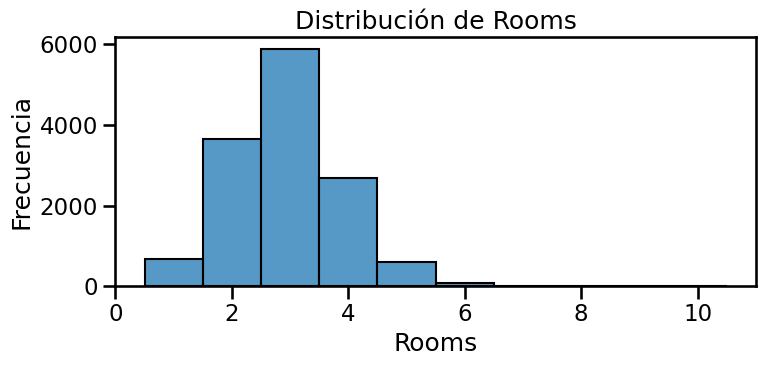

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


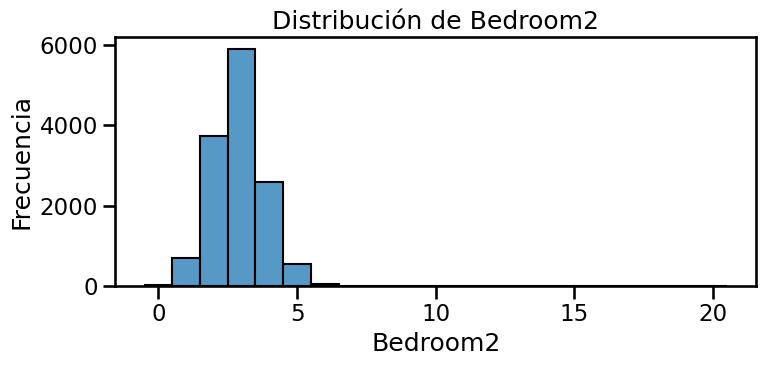

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


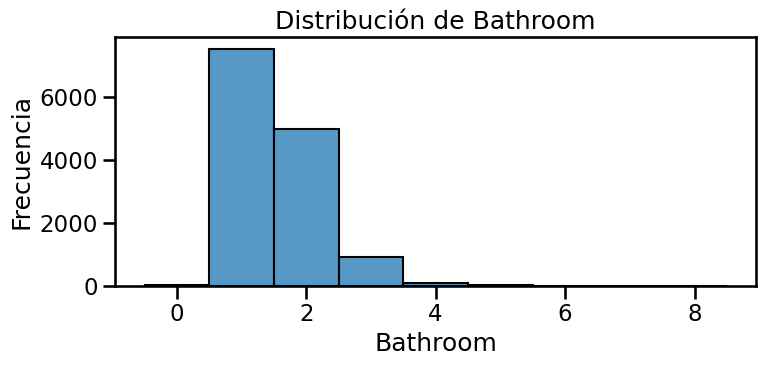

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


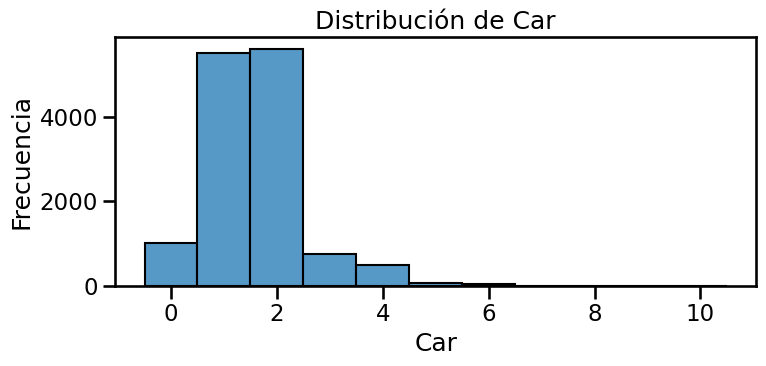

In [25]:
# Graficar discretas
for col in col_discretas:
    plt.figure(figsize=(8, 4))
    sns.histplot(melb_pd_df[col], bins=melb_pd_df[col].nunique(), discrete=True, kde=False)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


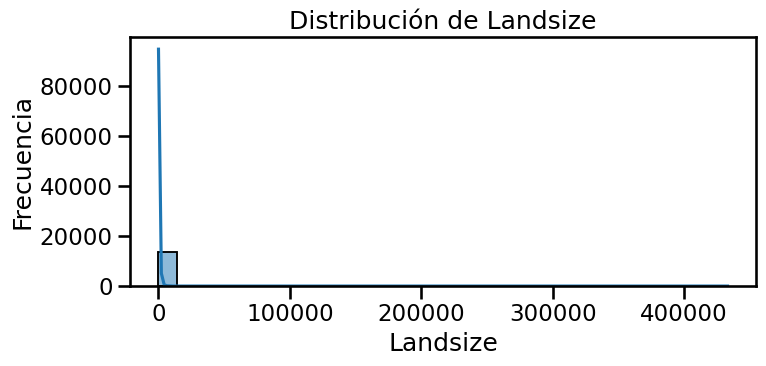

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


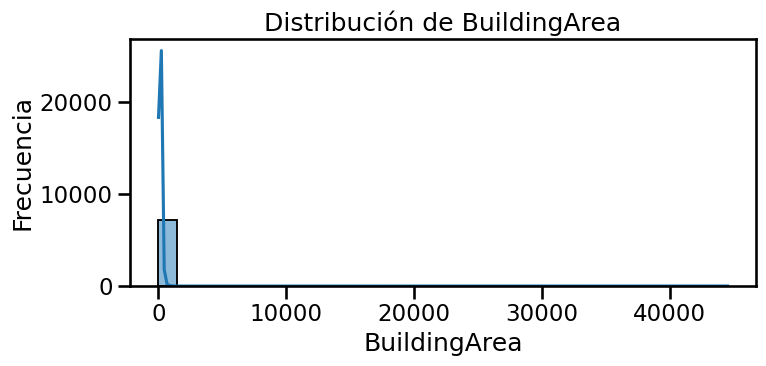

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


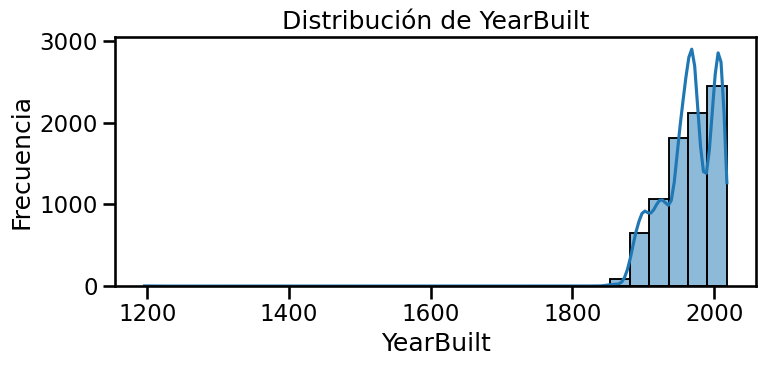

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


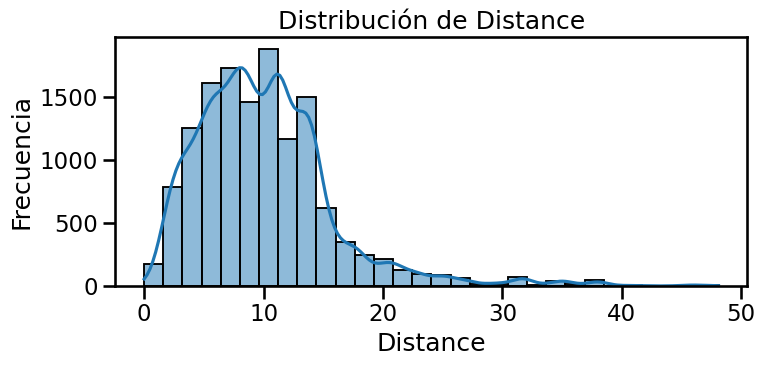

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


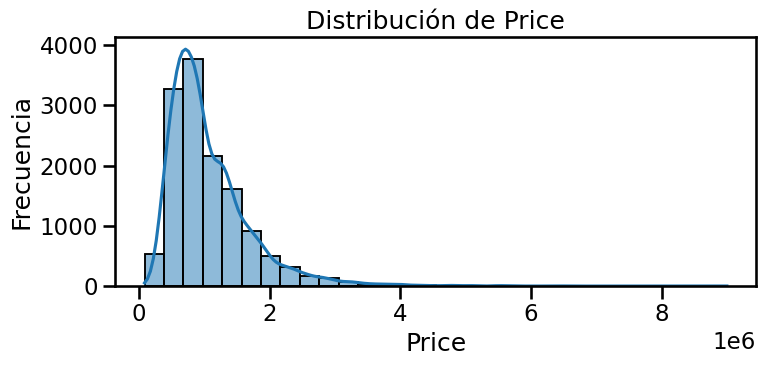

In [26]:
# Graficar continuas
for col in col_continuas:
    plt.figure(figsize=(8, 4))
    sns.histplot(melb_pd_df[col], bins=30, kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

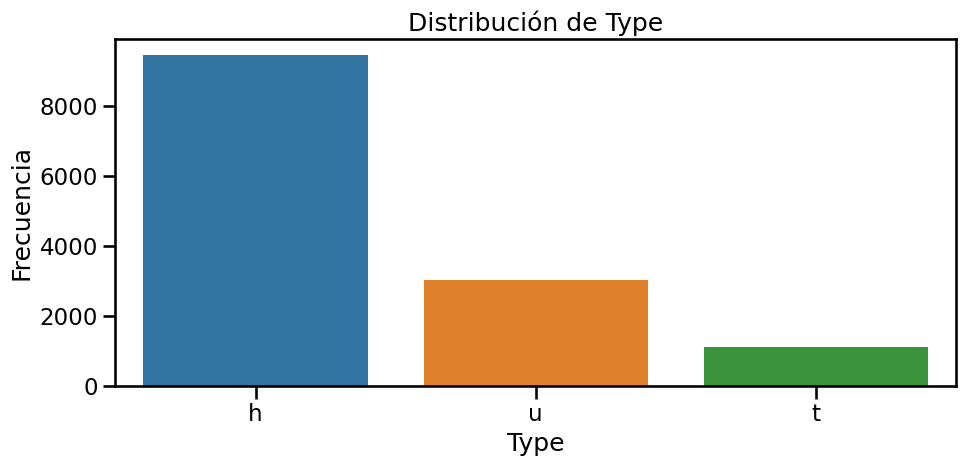

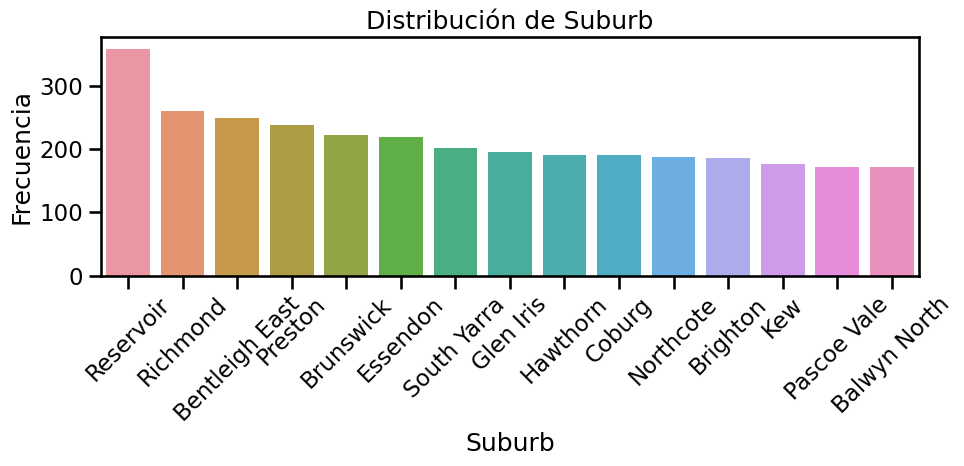

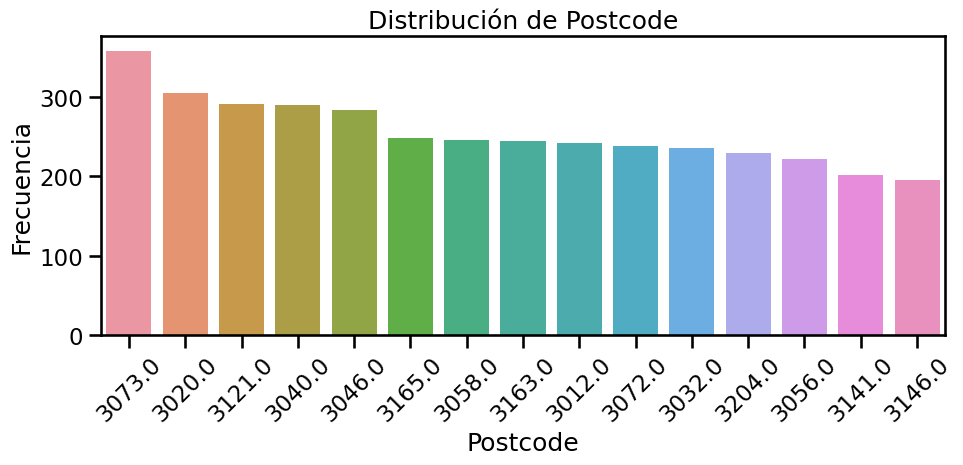

In [27]:
# Graficar categóricas (countplot)
for col in col_categoricas:
    plt.figure(figsize=(10, 5))
    if col == 'Suburb' or col=='Postcode':
        # Mostrar solo top 15
        top_vals = melb_pd_df[col].value_counts().nlargest(15).index
        sns.countplot(data=melb_pd_df[melb_pd_df[col].isin(top_vals)], x=col, order=top_vals)
        plt.xticks(rotation=45)
    else:
        sns.countplot(data=melb_pd_df, x=col, order=melb_pd_df[col].value_counts().index)

    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.show()

In [28]:
####### Ahora aplicamos un segundo filtro para eliminar las outliers calculando el IQR:#

# Variables numéricas (discretas + continuas)
col_numericas = col_discretas + col_continuas

# Función para eliminar outliers con el método IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# Aplicar a cada columna numérica
melb_clean_df = melb_pd_df.copy()
for col in col_numericas:
    melb_clean_df = remove_outliers_iqr(melb_clean_df, col)

# Comparar antes y después
print(f"Filas originales: {len(melb_pd_df)}")
print(f"Filas después de eliminar outliers: {len(melb_clean_df)}")
print(f"Porcentaje de datos eliminados: {(len(melb_pd_df) - len(melb_clean_df))*100/len(melb_pd_df):.2f}%")

Filas originales: 13580
Filas después de eliminar outliers: 5423
Porcentaje de datos eliminados: 60.07%


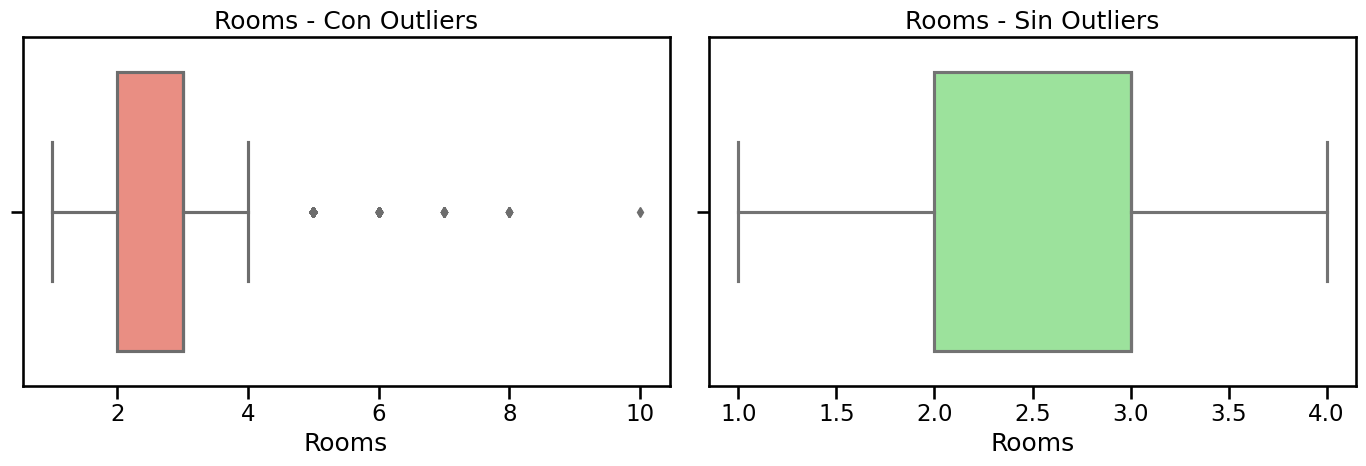

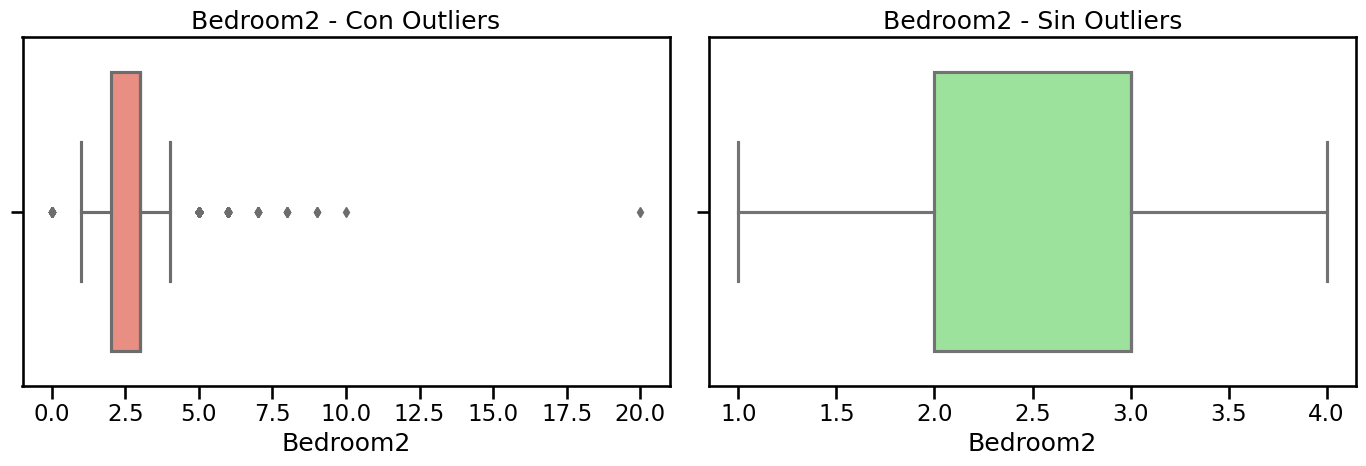

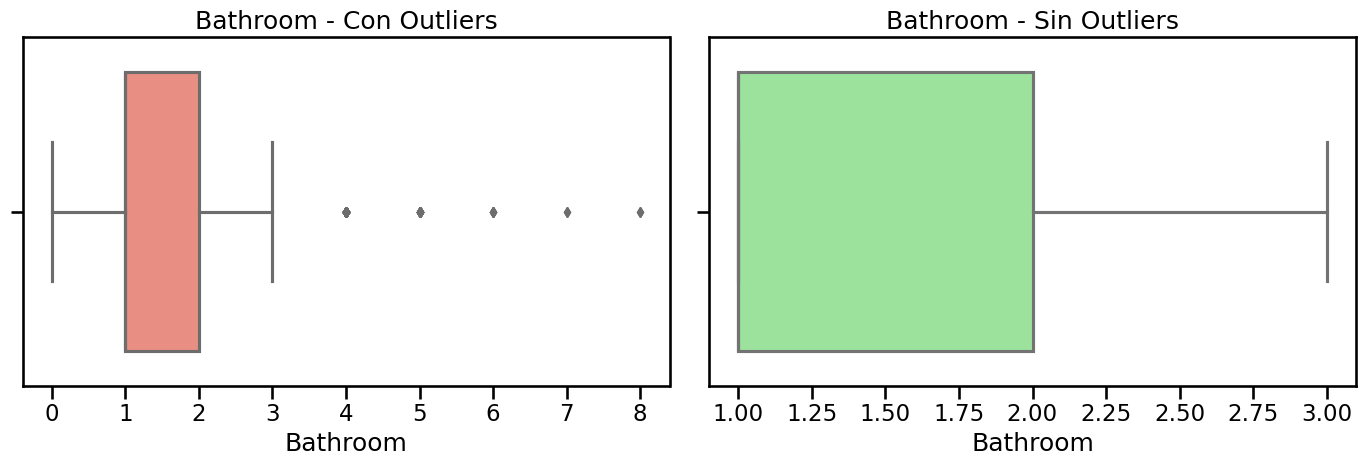

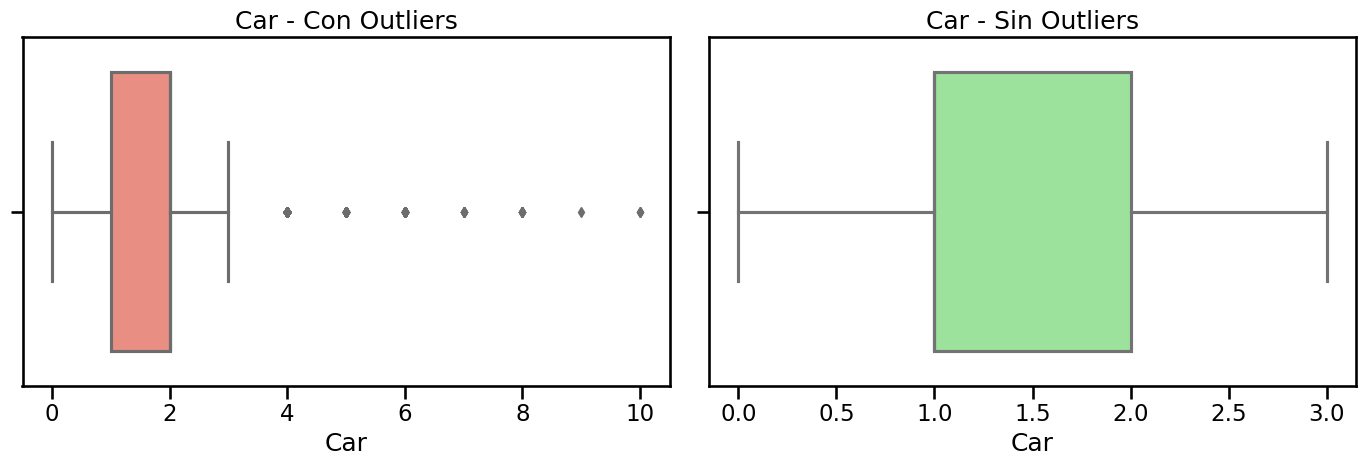

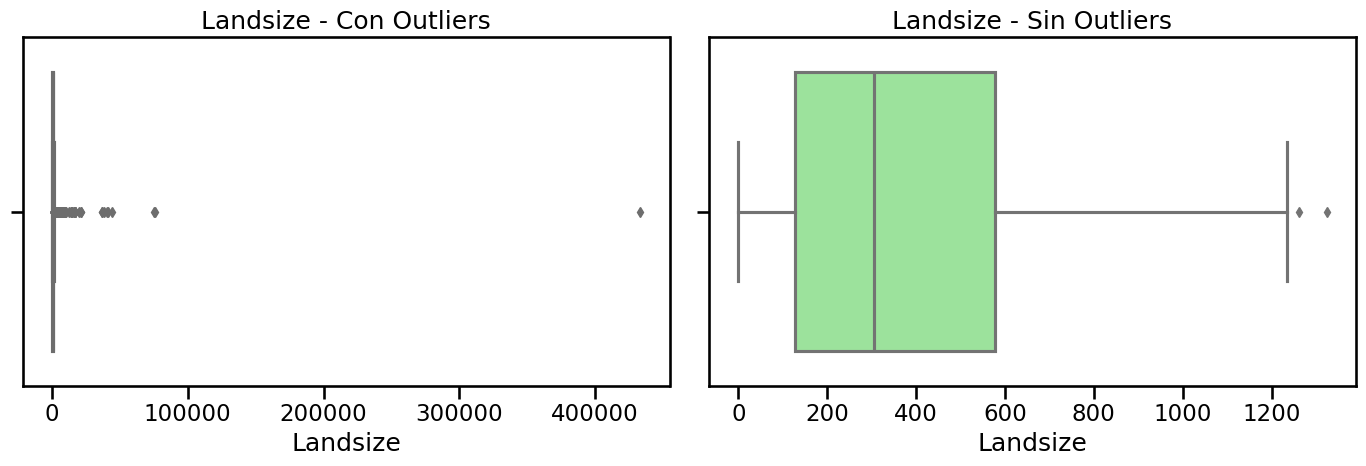

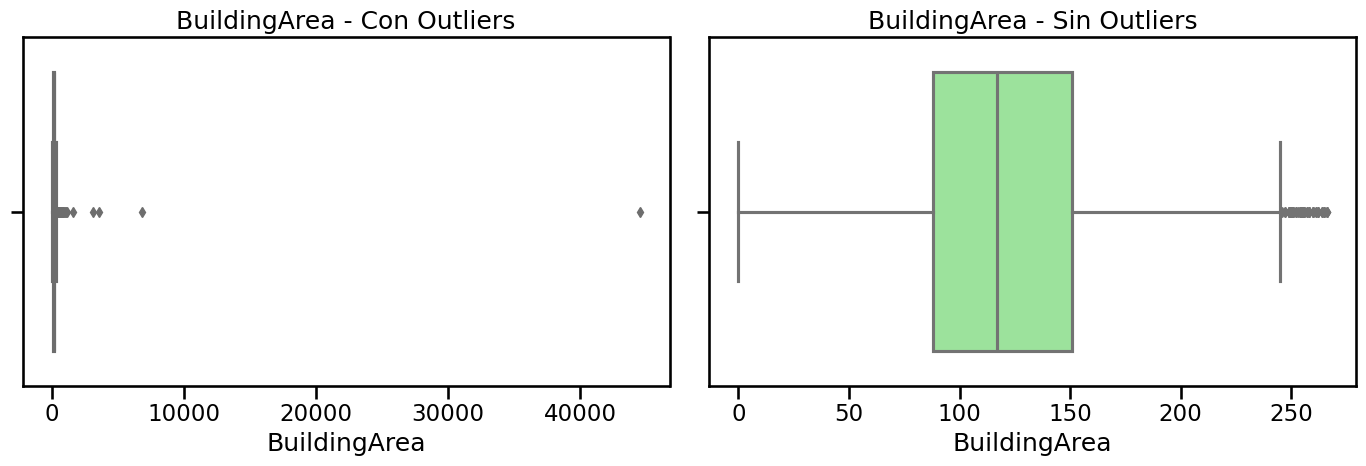

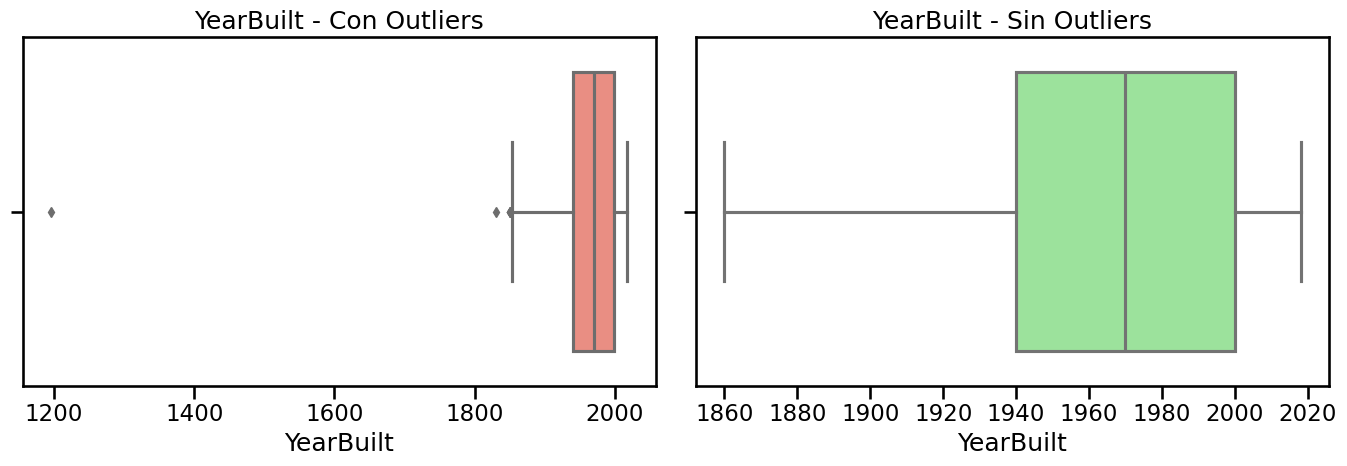

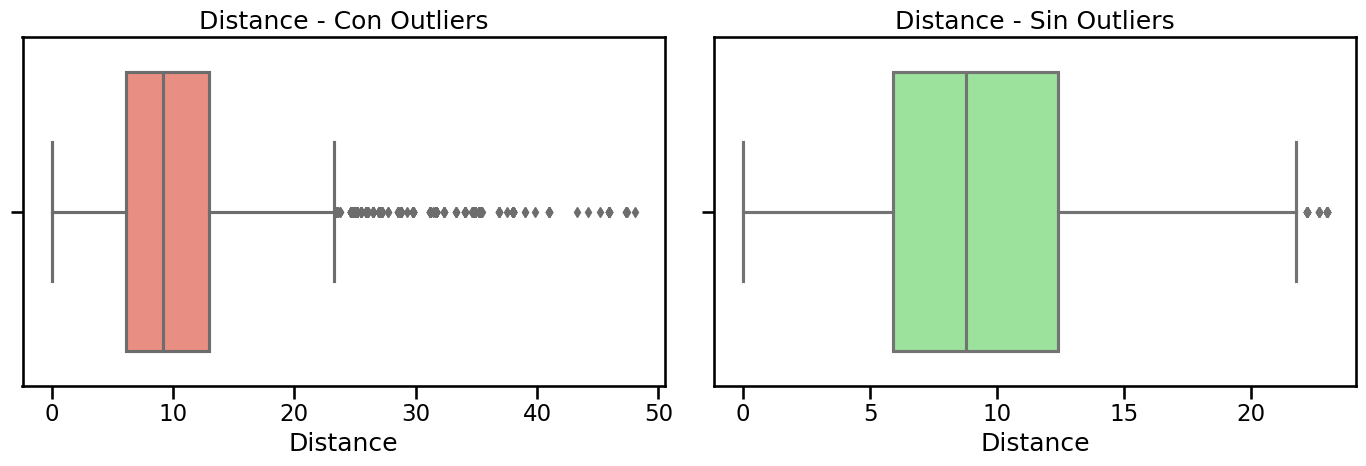

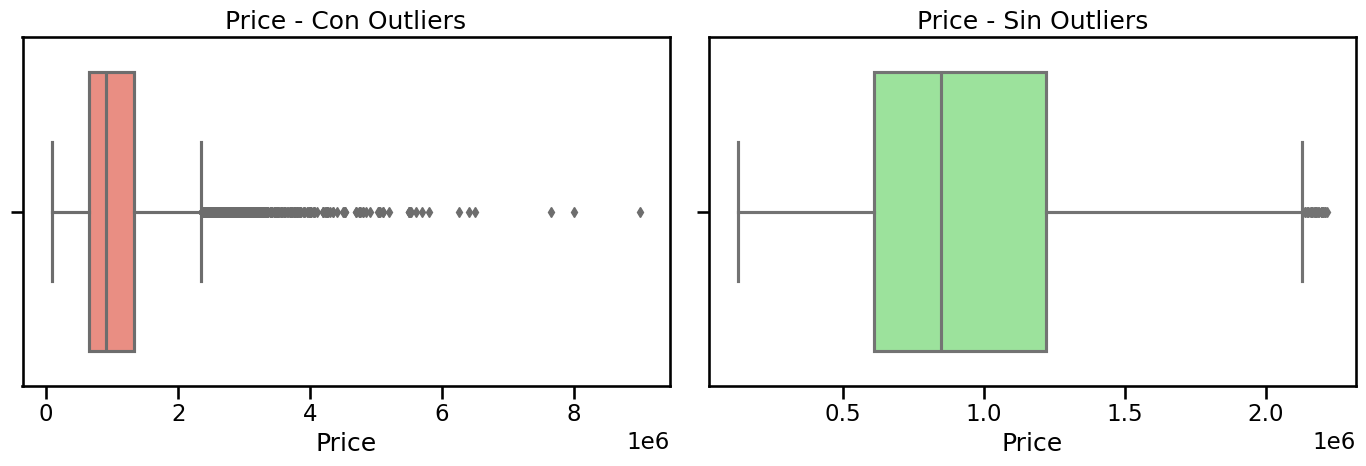

In [29]:
# Veamos los obxplot de las variables numéricas
# Variables numéricas (discretas + continuas)
col_numericas = col_discretas + col_continuas

for col in col_numericas:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Original con outliers
    sns.boxplot(ax=axes[0], data=melb_pd_df, x=col, color='salmon')
    axes[0].set_title(f'{col} - Con Outliers')

    # Sin outliers
    sns.boxplot(ax=axes[1], data=melb_clean_df, x=col, color='lightgreen')
    axes[1].set_title(f'{col} - Sin Outliers')

    plt.tight_layout()
    plt.show()

Vemos que eliminar todos los outliers elimina más del 60% de los datos, por lo que decidimos realizar una tarea más minuciosa para ver qué registros considerar. Nos enfocaremos en estudiar aquellos outliers correspondientes a regiones con menor densidad de datos.

#### Rooms

In [30]:
# Rooms
print("Rooms")
print("====================")
print(f'Valor\t|Ocurrencia')
print("====================")
valores = sorted(melb_pd_df["Rooms"].dropna().unique())
for n in valores:
    print(f"{int(n)}\t|\t{len(melb_pd_df[melb_pd_df['Rooms'] == n])}")
print("\nPropiedades con más de 8 rooms:\n")
print(melb_pd_df[melb_pd_df['Rooms']>=8].sort_values(by='Rooms', ascending=False),"\n\n")

Rooms
Valor	|Ocurrencia
1	|	681
2	|	3648
3	|	5881
4	|	2688
5	|	596
6	|	67
7	|	10
8	|	8
10	|	1

Propiedades con más de 8 rooms:

       Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
11304     10      10.0       3.0  2.0     313.0           NaN     2006.0   
379        8       9.0       7.0  4.0    1472.0         618.0     2009.0   
1926       8       4.0       2.0  4.0     983.0           NaN        NaN   
3255       8       8.0       4.0  4.0     638.0         115.0     1960.0   
4285       8       6.0       2.0  4.0     663.0         190.0     1920.0   
6201       8       6.0       4.0  3.0     668.0           NaN        NaN   
7581       8       8.0       3.0  3.0     614.0           NaN        NaN   
10611      8       8.0       8.0  4.0     650.0           NaN        NaN   
13226      8       8.0       3.0  1.0    1063.0         101.0     1980.0   

       Distance Type      Price              Suburb  Postcode  
11304      12.1    h   900000.0            Bund

Dado que nos es sospechoso que la propiedad con más habitaciones y más nueva tenga la menor superficie y uno de los precios más baratos. Esto, sumado a que, según investigamos, el suburbio al que pertenece es uno con zonas de residencias comerciales y residencias, baja tasa de delincuencia baja, buen transporte público y universidad, nos lleva a descartar este registro con Rooms=10.

In [31]:
# Eliminamos registro con Rooms = 10
melb_filtered_1 = melb_pd_df[melb_pd_df['Rooms'] != 10]
print(f'Tamaño de DB ANTES de este paso de limpieza: {len(melb_pd_df)}')
print(f'Tamaño de DB DESPUÉS de este paso de limpieza: {len(melb_filtered_1)}')

Tamaño de DB ANTES de este paso de limpieza: 13580
Tamaño de DB DESPUÉS de este paso de limpieza: 13579


#### Bedroom2

In [32]:
# Bedroom2
print("Bedroom2")
print("====================")
print(f'Valor\t|Ocurrencia')
print("====================")
valores = sorted(melb_filtered_1["Bedroom2"].dropna().unique())
for n in valores:
    print(f"{int(n)}\t|\t{len(melb_filtered_1[melb_filtered_1['Bedroom2'] == n])}")

print("Propiedades con más de 7 Bedroom2:")
print(melb_filtered_1[melb_filtered_1['Bedroom2']>=7].sort_values(by='Bedroom2', ascending=False),"\n\n")



Bedroom2
Valor	|Ocurrencia
0	|	16
1	|	691
2	|	3737
3	|	5896
4	|	2601
5	|	556
6	|	63
7	|	10
8	|	5
9	|	3
20	|	1
Propiedades con más de 7 Bedroom2:
       Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
7404       3      20.0       1.0  2.0     875.0           NaN        NaN   
6915       3       9.0       6.0  2.0     592.0        103.00     1960.0   
379        8       9.0       7.0  4.0    1472.0        618.00     2009.0   
4980       4       9.0       8.0  7.0    1254.0        280.00     1928.0   
3255       8       8.0       4.0  4.0     638.0        115.00     1960.0   
10611      8       8.0       8.0  4.0     650.0           NaN        NaN   
7581       8       8.0       3.0  3.0     614.0           NaN        NaN   
235        5       8.0       2.0  2.0     693.0           NaN        NaN   
13226      8       8.0       3.0  1.0    1063.0        101.00     1980.0   
2452       6       7.0       2.0  2.0     870.0           NaN        NaN   
1417       7       

El registro con 20 dormitorios no parece tener sentido, puesto que necesitaría mucho más de un baño y 3 ambientes. Se decide eliminar este registro:

In [33]:
# Eliminamos registro con Bedroom2 = 20
melb_filtered_2 = melb_filtered_1[melb_filtered_1['Bedroom2'] != 20]
print(f'Tamaño de DB ANTES de este paso de limpieza: {len(melb_filtered_1)}')
print(f'Tamaño de DB DESPUÉS de este paso de limpieza: {len(melb_filtered_2)}')

Tamaño de DB ANTES de este paso de limpieza: 13579
Tamaño de DB DESPUÉS de este paso de limpieza: 13578


Por otro lado, observamos que no debe tener sentido el caso en que Rooms sea mayor a Bedroom2: Si el primero corresponde a la cantidad total de ambientes, debe ser mayor a la cantidad total de dormitorios.

Por otro lado, hay casos en los que ambas cantidades coinciden, pero es posible que muchas personas que completaron el campo Rooms en Domain.com.au hayan escrito la cantidad de dormitorios. Bedroom2 es sacada de otra fuente. Esto nos lleva a conservar los casos en los que Rooms = Bedroom2.

In [34]:
# Veamos aquellas propiedades para las cuales bedrooms2 > rooms:
melb_strange_bedrooms = melb_filtered_2[melb_filtered_2['Bedroom2']>melb_filtered_2['Rooms']]
print(f"Cantidad de propiedades que tienen más dormitorios que habitaciones: {len(melb_strange_bedrooms)}")
print(f"En porcentaje: {len(melb_strange_bedrooms)*100/len(melb_filtered_2):.2f}%\n")
print(melb_strange_bedrooms)

Cantidad de propiedades que tienen más dormitorios que habitaciones: 202
En porcentaje: 1.49%

       Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
6          3       4.0       2.0  0.0     245.0         210.0     1910.0   
9          2       3.0       1.0  2.0     220.0          75.0     1900.0   
63         4       5.0       3.0  4.0     531.0         309.0     1980.0   
207        3       5.0       2.0  2.0     276.0         100.0     2010.0   
233        2       3.0       2.0  2.0       0.0           NaN     2006.0   
...      ...       ...       ...  ...       ...           ...        ...   
11536      3       4.0       1.0  2.0     909.0           NaN        NaN   
11579      3       4.0       2.0  2.0     612.0         154.0     1960.0   
11846      1       2.0       1.0  1.0       0.0           NaN     1970.0   
12411      3       4.0       2.0  3.0     530.0         145.0     1950.0   
12926      3       4.0       2.0  2.0     788.0         108.0     196

In [35]:
# Eliminamos los registros en los que Bedroom2 > Rooms
melb_filtered_3 = melb_filtered_2[melb_filtered_2['Bedroom2']<=melb_filtered_2['Rooms']]
print(f"Tamaño Original: {len(melb_filtered_2)}")
print(f"Tamaño de base de datos filtrada: {len(melb_filtered_3)}")

Tamaño Original: 13578
Tamaño de base de datos filtrada: 13376


#### Bathroom

In [36]:
# Bathroom
print("Bathroom")
print("====================")
print(f'Valor\t|Ocurrencia')
print("====================")
valores = sorted(melb_filtered_3["Bathroom"].dropna().unique())
for n in valores:
    print(f"{int(n)}\t|\t{len(melb_filtered_3[melb_filtered_3['Bathroom'] == n])}")

print("Propiedades con más de 6 Bathroom:")
print(melb_filtered_3[melb_filtered_3['Bathroom']>=6].sort_values(by='Bathroom', ascending=False),"\n\n")

print("Veamos las propiedades con 0 Bathroom:")
print(melb_filtered_3[melb_filtered_3['Bathroom']==0],"\n\n")

Bathroom
Valor	|Ocurrencia
0	|	32
1	|	7411
2	|	4898
3	|	898
4	|	104
5	|	28
6	|	3
7	|	1
8	|	1
Propiedades con más de 6 Bathroom:
       Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
10611      8       8.0       8.0  4.0     650.0           NaN        NaN   
580        5       5.0       7.0  6.0       0.0           NaN        NaN   
557        5       5.0       6.0  4.0     739.0         502.0        NaN   
3616       6       6.0       6.0  3.0    1334.0         365.0     1890.0   
10653      5       5.0       6.0  3.0     900.0         178.0     1960.0   

       Distance Type      Price      Suburb  Postcode  
10611       7.7    h  2200000.0  Camberwell    3124.0  
580         9.7    h  3900000.0      Balwyn    3103.0  
557         9.7    h  3400000.0      Balwyn    3103.0  
3616        5.6    h  6500000.0         Kew    3101.0  
10653      27.0    h  1260000.0   Edithvale    3196.0   


Veamos las propiedades con 0 Bathroom:
       Rooms  Bedroom2  Bathroom  Car

Eliminamos los registros en los que Bathroom = 0, al considerarlo sin sentido.

In [37]:
# Eliminamos los registros con Bathroom = 0
melb_filtered_4 = melb_filtered_3[melb_filtered_3['Bathroom'] != 0]
print(f'Tamaño de DB ANTES de este paso de limpieza: {len(melb_filtered_3)}')
print(f'Tamaño de DB DESPUÉS de este paso de limpieza: {len(melb_filtered_4)}')

Tamaño de DB ANTES de este paso de limpieza: 13376
Tamaño de DB DESPUÉS de este paso de limpieza: 13344


Por otro lado, consideramos sin sentido tener muchos más Bathroom que Rooms. Por ello, decidimos eliminar aquellos registros en los que Bathroom sea mayor al doble de Rooms:

In [38]:
# Veamos cuántos registros tienen Bathroom > Rooms
melb_bathrooms_atipicos = melb_filtered_4[melb_filtered_4['Bathroom'] > melb_filtered_4['Rooms']]
print(f'Cantidad de datos en los que Bathroom alcanza o supera el doble de Rooms: {len(melb_bathrooms_atipicos)}')
print(f'Porcentaje de registros en los que Bathroom alcanza o supera el doble de Rooms: {len(melb_bathrooms_atipicos)*100/len(melb_filtered_4):.2f}%')

Cantidad de datos en los que Bathroom alcanza o supera el doble de Rooms: 19
Porcentaje de registros en los que Bathroom alcanza o supera el doble de Rooms: 0.14%


In [39]:
# Eliminamos los registros con más baños que habitaciones
melb_filtered_5 = melb_filtered_4[melb_filtered_4['Bathroom'] <= melb_filtered_4['Rooms']]
print(f"Tamaño Original: {len(melb_filtered_4)}")
print(f"Tamaño de base de datos filtrada: {len(melb_filtered_5)}")

Tamaño Original: 13344
Tamaño de base de datos filtrada: 13325


#### Car

In [40]:
# Car
print("Car")
print("====================")
print(f'Valor\t|Ocurrencia')
print("====================")
valores = sorted(melb_filtered_5["Car"].dropna().unique())
for n in valores:
    print(f"{int(n)}\t|\t{len(melb_filtered_5[melb_filtered_5['Car'] == n])}")

print("Propiedades con más de 7 Car:")
print(melb_filtered_5[melb_filtered_5['Car']>=7].sort_values(by='Car', ascending=False),"\n\n")

Car
Valor	|Ocurrencia
0	|	976
1	|	5431
2	|	5490
3	|	738
4	|	496
5	|	61
6	|	52
7	|	7
8	|	8
9	|	1
10	|	3
Propiedades con más de 7 Car:
       Rooms  Bedroom2  Bathroom   Car  Landsize  BuildingArea  YearBuilt  \
13527      4       4.0       2.0  10.0    1002.0         170.0     1985.0   
11642      3       3.0       2.0  10.0     734.0           NaN        NaN   
9423       4       4.0       1.0  10.0     993.0         128.0     1966.0   
8963       3       3.0       1.0   9.0     841.0         124.0     1960.0   
13137      4       4.0       2.0   8.0     905.0           NaN        NaN   
12268      3       3.0       1.0   8.0    1082.0           NaN        NaN   
11993      3       3.0       1.0   8.0     665.0           NaN        NaN   
476        3       3.0       2.0   8.0     585.0           NaN        NaN   
4506       4       4.0       4.0   8.0    1390.0           NaN     1912.0   
3940       4       4.0       3.0   8.0     865.0         374.0     2013.0   
2941       4       4

No logramos decidir un criterio para filtrar registros por cantidad de espacios para autos. Entendemos, según averiguamos, que es normal que las familias en Australia tengan muchos vehículos. Esto, junto con la falta de información más precisa respecto al significado o la recolección de los datos, nos fificulta formar un criterio para establecer razonabilidad de la cantidad de espacios para autos en función de otras variables como, por ejemplo, la cantidad de habitaciones.

#### Landsize

In [41]:
print("=================================")
print("Landsize")
print("=================================")
print(melb_filtered_5['Landsize'].describe())
print("=================================\n")

Landsize
count     13325.000000
mean        560.978086
std        4028.304888
min           0.000000
25%         178.000000
50%         441.000000
75%         651.000000
max      433014.000000
Name: Landsize, dtype: float64



In [42]:
# Veamos las propiedades con landsize mayor a 400000
print(melb_filtered_5[melb_filtered_5['Landsize']>=400000])

       Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
11020      3       3.0       3.0  1.0  433014.0           NaN        NaN   

       Distance Type      Price   Suburb  Postcode  
11020       2.1    h  2700000.0  Fitzroy    3065.0  


Considerando que el registro anterior tiene muy pocas habitaciones, y un precio demasiado bajo para estar tan cerca del centro y ser tan grande, lo descartamos.

In [43]:
# Eliminamos los que tienen Landsize mayor a 400000
melb_filtered_6 = melb_filtered_5[melb_filtered_5['Landsize'] < 400000]
print(f'Tamaño de DB ANTES de este paso de limpieza: {len(melb_filtered_5)}')
print(f'Tamaño de DB DESPUÉS de este paso de limpieza: {len(melb_filtered_6)}')

Tamaño de DB ANTES de este paso de limpieza: 13325
Tamaño de DB DESPUÉS de este paso de limpieza: 13324


Landsize
count    13324.000000
mean       528.521390
std       1479.984736
min          0.000000
25%        178.000000
50%        441.000000
75%        651.000000
max      76000.000000
Name: Landsize, dtype: float64



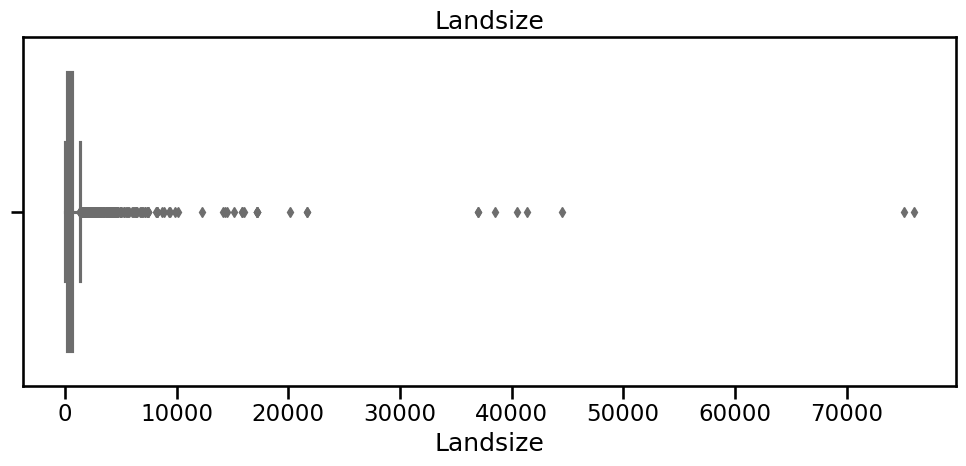

In [44]:
# Volvamos a ver el boxplot de Landsize ahora sin el último registro eliminado
print("=================================")
print("Landsize")
print("=================================")
print(melb_filtered_6['Landsize'].describe())
print("=================================\n")


plt.figure(figsize=(10, 5))
sns.boxplot(data=melb_filtered_6, x='Landsize', color='salmon')
plt.title('Landsize')

plt.tight_layout()
plt.show()

In [45]:
# Veamos las propiedades con Landsize por encima de 10000
print(melb_filtered_6[melb_filtered_6['Landsize']>=10000].sort_values(by='Landsize', ascending=False))

       Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
10504      3       3.0       2.0  2.0   76000.0           NaN        NaN   
687        3       3.0       1.0  2.0   75100.0           NaN        NaN   
13245      5       5.0       3.0  5.0   44500.0       44515.0        NaN   
5194       3       3.0       1.0  2.0   41400.0           NaN        NaN   
11371      4       4.0       2.0  3.0   40468.0           NaN        NaN   
10045      4       4.0       2.0  3.0   38490.0           NaN        NaN   
9223       2       2.0       2.0  2.0   37000.0          90.0     2004.0   
3942       2       2.0       2.0  2.0   37000.0           NaN        NaN   
8241       2       2.0       2.0  2.0   21715.0          99.0     2005.0   
4706       2       2.0       2.0  2.0   21700.0           NaN     2000.0   
12504      4       4.0       3.0  2.0   20200.0         189.0     1985.0   
12163      2       2.0       2.0  2.0   17200.0           NaN     2000.0   
10819      2

Todas las propiedades listadas arriba tienen superficies mayores a una hectárea. Para dicho tamaño, se ve que tienen poca cantidad de habitaciones. Esto tiene sentido en área rurales (muy alejadas del centro de Melbourne), pero no en urbanas (cercanas al centro de Melbourne). Decidimos enfocarnos en áreas urbanas, y por otro lado descartar aquellos casos en los que las superficies del terreno sean muy grandes para las prestaciones de la propiedad que aparecen en la tabla:

In [46]:
# Eliminamos los que tienen Landsize mayor a 10000
melb_filtered_7 = melb_filtered_6[melb_filtered_6['Landsize'] < 10000]
print(f'Tamaño de DB ANTES de este paso de limpieza: {len(melb_filtered_6)}')
print(f'Tamaño de DB DESPUÉS de este paso de limpieza: {len(melb_filtered_7)}')

Tamaño de DB ANTES de este paso de limpieza: 13324
Tamaño de DB DESPUÉS de este paso de limpieza: 13299


Vemos que, por otro lado, hay registros con Landsize nulo. Veamos cuántos son:

In [47]:
# Cantidad de registros con Landsize == 0:
print(f"Cantidad de registros con Landize=0: {len(melb_filtered_7[melb_filtered_7['Landsize']==0])}")
print(f"Porcentaje de registros con Landize=0: {len(melb_filtered_7[melb_filtered_7['Landsize']==0])*100/len(melb_filtered_7):.2f}%")

Cantidad de registros con Landize=0: 1887
Porcentaje de registros con Landize=0: 14.19%


Dado que son muchos, Vamos a ver cuántos de estos registros podemos rescatar gracias a la variable 'BuildingArea".

#### BuildingArea

In [48]:
print("=================================")
print("BuildingArea")
print("=================================")
print(melb_filtered_7['BuildingArea'].describe())
print("=================================\n")

BuildingArea
count    7016.000000
mean      144.708359
std       121.345955
min         0.000000
25%        93.000000
50%       126.000000
75%       173.000000
max      6791.000000
Name: BuildingArea, dtype: float64



In [49]:
# Veamos la cantidad de propiedades con (Landsize = 0 O NaN) Y (BuildingArea = 0 O NaN)
filtro = (
    (melb_filtered_7['Landsize'].isin([0]) | 
    melb_filtered_7['Landsize'].isna()) & 
    (melb_filtered_7['BuildingArea'].isin([0]) | 
    melb_filtered_7['BuildingArea'].isna())
)
print(f"Cantidad de propiedades sin información adecuada de Landsize ni de BuildingArea: {len(melb_filtered_7[filtro])}")
print(f"Porcentaje de propiedades sin información adecuada de Landsize ni de BuildingArea: {len(melb_filtered_7[filtro])*100/len(melb_filtered_7):.2f}%")

Cantidad de propiedades sin información adecuada de Landsize ni de BuildingArea: 839
Porcentaje de propiedades sin información adecuada de Landsize ni de BuildingArea: 6.31%


Eliminamos los registros que no nos proporcionen información fiable de la superficie del terreno ni del área construida.

In [50]:
# Eliminamos los que no tienen información fiable Landsize ni de BuildingArea
filtro = (
    (melb_filtered_7['Landsize'].isin([0]) | 
    melb_filtered_7['Landsize'].isna()) & 
    (melb_filtered_7['BuildingArea'].isin([0]) | 
    melb_filtered_7['BuildingArea'].isna())
)
melb_filtered_8 = melb_filtered_7[~filtro]
print(f'Tamaño de DB ANTES de este paso de limpieza: {len(melb_filtered_7)}')
print(f'Tamaño de DB DESPUÉS de este paso de limpieza: {len(melb_filtered_8)}')

Tamaño de DB ANTES de este paso de limpieza: 13299
Tamaño de DB DESPUÉS de este paso de limpieza: 12460


Por otro lado, es un sinsentido que el área construida sea mayor que el área total del terreno. Veamos cuántos registros tienen este defecto:

In [51]:
# Veamos las propiedades con BuildingArea mayor que Landsize
print(f"Cantidad de registros con área construida mayor que área de terreno: {len(melb_filtered_8[melb_filtered_8['Landsize']<melb_filtered_8['BuildingArea']])}")
print(f"Porcentaje de registros con área construida mayor que área de terreno: {len(melb_filtered_8[melb_filtered_8['Landsize']<melb_filtered_8['BuildingArea']])*100/len(melb_filtered_8):.2f}%")

Cantidad de registros con área construida mayor que área de terreno: 1302
Porcentaje de registros con área construida mayor que área de terreno: 10.45%


Eliminamos los registros que tienen el defecto anterior:

In [52]:
# Eliminamos los que tienen Landsize mayor a 10000
melb_filtered_9 = melb_filtered_8[~(melb_filtered_8['Landsize'] < melb_filtered_8['BuildingArea'])]
print(f'Tamaño de DB ANTES de este paso de limpieza: {len(melb_filtered_8)}')
print(f'Tamaño de DB DESPUÉS de este paso de limpieza: {len(melb_filtered_9)}')

Tamaño de DB ANTES de este paso de limpieza: 12460
Tamaño de DB DESPUÉS de este paso de limpieza: 11158


#### YearBuilt

In [53]:
print("=================================")
print('YearBuilt')
print("=================================")
print(melb_filtered_9['YearBuilt'].describe())
print("=================================\n")

YearBuilt
count    6561.000000
mean     1961.765585
std        37.850616
min      1196.000000
25%      1938.000000
50%      1965.000000
75%      1995.000000
max      2017.000000
Name: YearBuilt, dtype: float64



In [54]:
# Descartamos las propiedades con años de construcción anterior a 1800
melb_filtered_10 = melb_filtered_9[
    (melb_filtered_9['YearBuilt'] > 1800) | 
    (melb_filtered_9['YearBuilt'].isna())
]
print(f"Cantidad de registros ANTES de este filtrado: {len(melb_filtered_9)}")
print(f"Cantidad de registros DESPUÉS de este filtrado: {len(melb_filtered_10)}")

Cantidad de registros ANTES de este filtrado: 11158
Cantidad de registros DESPUÉS de este filtrado: 11157


#### Distance

In [55]:
print("=================================")
print('Distance')
print("=================================")
print(melb_filtered_10['Distance'].describe())
print("=================================\n")

Distance
count    11157.000000
mean        10.883141
std          5.924718
min          0.000000
25%          7.000000
50%         10.400000
75%         13.700000
max         47.400000
Name: Distance, dtype: float64



No vemos distancias particularmente extrañas, entendiendo que el gran Melbourn tiene casi $4000\ mi^2$ (~$10.000\ km^2$).

#### Price

In [56]:
print("=================================")
print('Price')
print("=================================")
print(melb_filtered_10['Price'].describe())
print("=================================\n")

Price
count    1.115700e+04
mean     1.145167e+06
std      6.476953e+05
min      1.310000e+05
25%      7.100000e+05
50%      9.700000e+05
75%      1.400000e+06
max      9.000000e+06
Name: Price, dtype: float64



In [57]:
# Revisamos propiedades con Price mayores a 5E6

print(f"Cantidad de registros con precios mayores a 5.000.000: {len(melb_filtered_10[melb_filtered_10['Price']>5E6])}\n\n")
print(melb_filtered_10[melb_filtered_10['Price']>5E6].sort_values(by='Landsize', ascending=False))

Cantidad de registros con precios mayores a 5.000.000: 21


       Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
7692       5       5.0       5.0  4.0    2079.0         464.3     1880.0   
9575       4       4.0       2.0  4.0    1690.0         284.0     1863.0   
251        6       5.0       3.0  4.0    1491.0         516.0     1935.0   
3616       6       6.0       6.0  3.0    1334.0         365.0     1890.0   
5801       5       5.0       3.0  3.0    1294.0         378.0     1884.0   
7554       5       5.0       4.0  4.0    1276.0           NaN     1880.0   
3114       3       3.0       2.0  3.0    1038.0           NaN        NaN   
3188       4       4.0       4.0  2.0     905.0         373.0     1913.0   
7684       4       4.0       4.0  3.0     892.0           NaN        NaN   
12762      5       5.0       4.0  2.0     892.0           NaN     1917.0   
6345       4       4.0       4.0  5.0     877.0         332.0     1923.0   
12239      5       5.0      

En las propiedades listadas arriba no se encuentran características que las diferencien de otras propiedades más baratas (como cantidad de habitaciones, de lugares para autos o superficies), de hecho, hay propiedades más baratas con mejores características. Dado que, además, los precios de estos registros se distancian por mucho de la gran mayoría del resto, decidimos eliminarlos.

In [58]:
# Descartamos las propiedades con años de construcción anterior a 1800
melb_filtered_11 = melb_filtered_10[
    (melb_filtered_10['Price'] < 5E6)
]
print(f"Cantidad de registros ANTES de este filtrado: {len(melb_filtered_10)}")
print(f"Cantidad de registros DESPUÉS de este filtrado: {len(melb_filtered_11)}")

Cantidad de registros ANTES de este filtrado: 11157
Cantidad de registros DESPUÉS de este filtrado: 11136


## Resumen de los filtros aplicados

Se eliminaron los registros que cumplen alguna de las siguientes características:

    1. Registro con 10 ambientes o habitaciones (Rooms  = 10)
    2. Registro con 20 dormitorios (Bedroom2 = 20)
    3. Registros donde Rooms<Bedroom2
    4. Registros con Bathroom = 0
    5. Registros con Bathroom > Rooms
    6. Registro con Landsize mayor a 10.000
    7. Registros sin información fiable de Landsize ni de BuildingArea, es decir, aquellos para los cuales ambas variables tienen valores nulos o no asignados.
    8. Registros con BuildingArea mayor que Landsize
    9. Registros con años de construcción anteriores a 1800
    10.Registros con precios mayores a 5.000.000.
    
Con estos filtros, de los 13.580 registros originales, nos quedamos con 11.136, es decir, el 82,00%.
    
Veamos cómo quedan las visualizaciones de los datos con estos filtros:

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


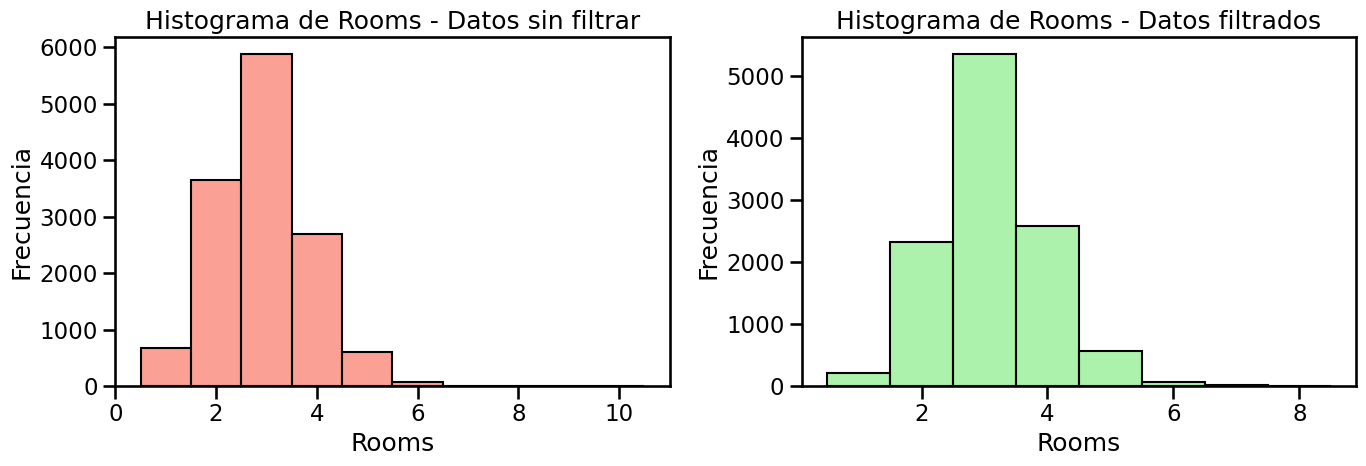

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


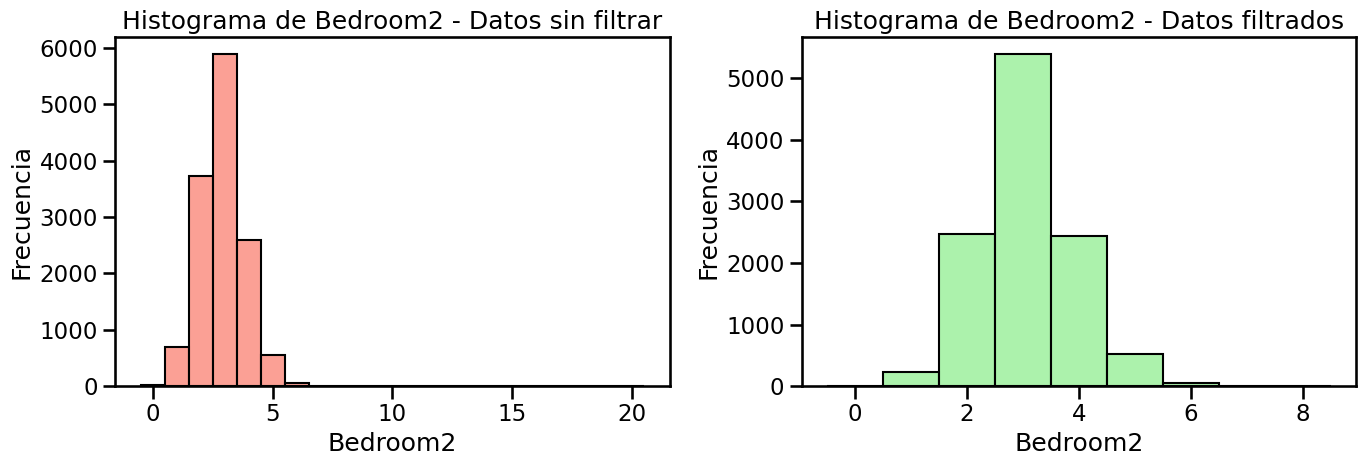

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


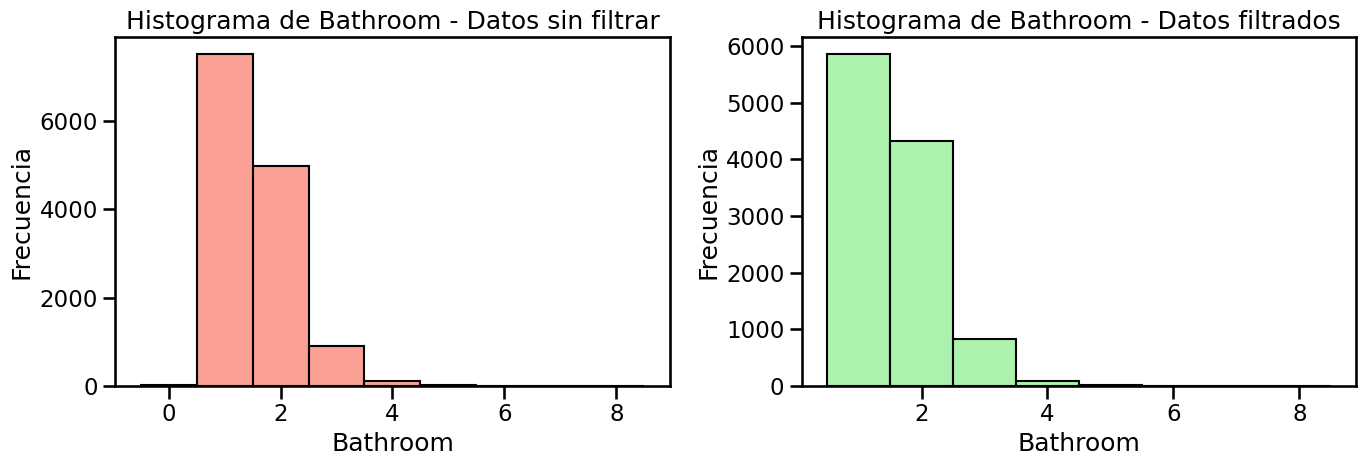

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


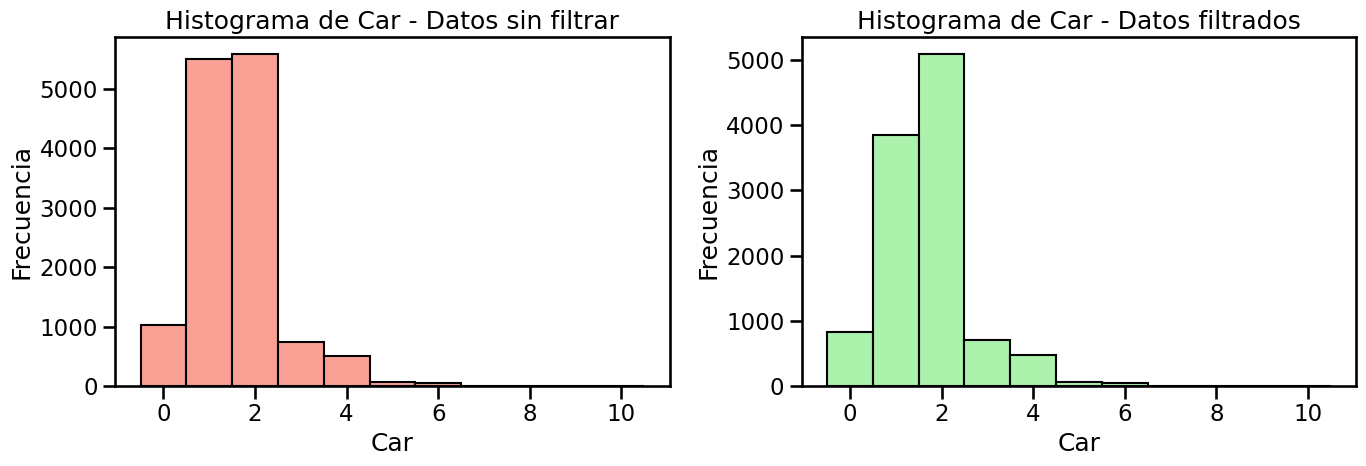

In [59]:
# Graficar discretas
for col in col_discretas:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histograma con datos originales
    sns.histplot(melb_pd_df[col], ax=axes[0], bins=melb_pd_df[col].nunique(), discrete=True, kde=False, color='salmon')
    axes[0].set_title(f'Histograma de {col} - Datos sin filtrar')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frecuencia')
    
    # Histograma con datos filtrados
    sns.histplot(melb_filtered_11[col], ax=axes[1], bins=melb_filtered_11[col].nunique(), discrete=True, kde=False, color='lightgreen')
    axes[1].set_title(f'Histograma de {col} - Datos filtrados')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


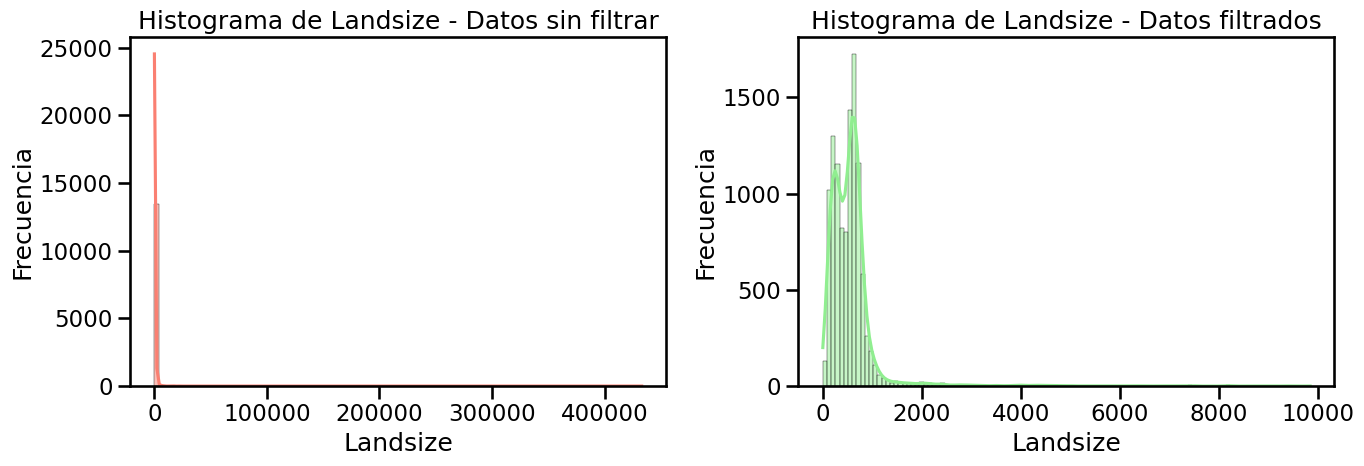

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


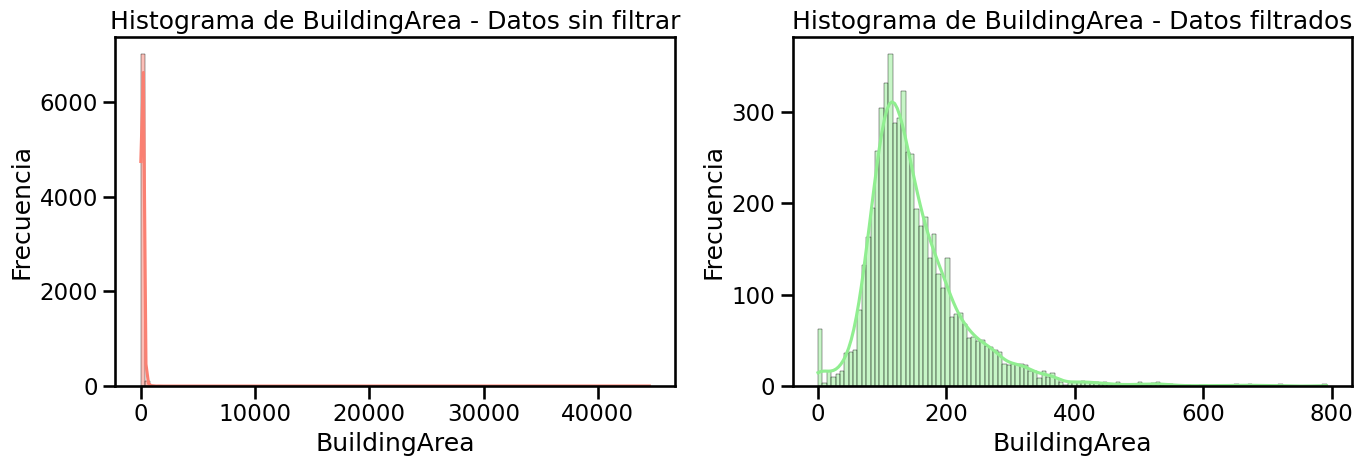

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


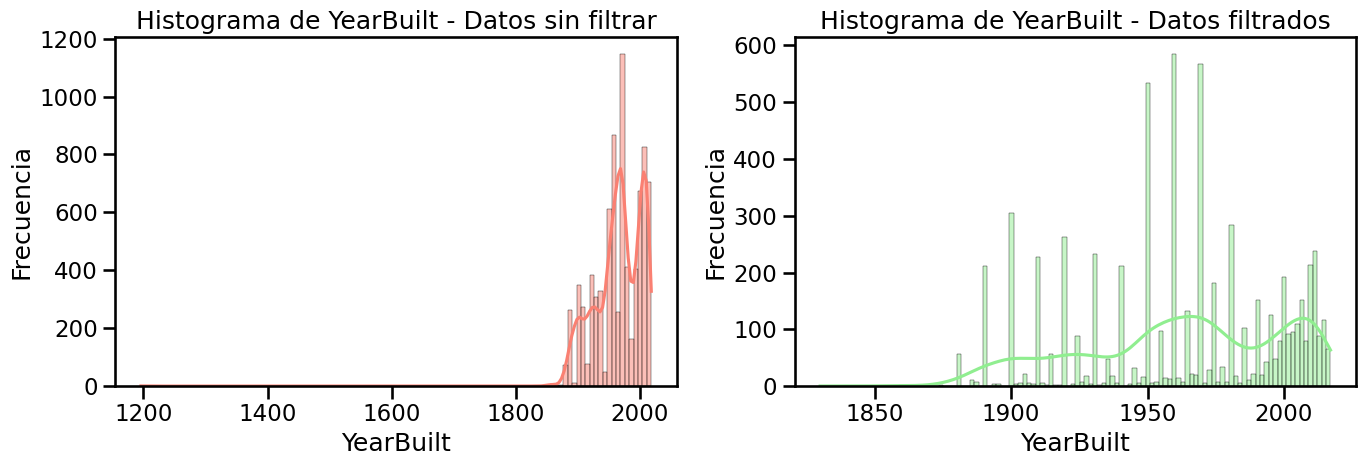

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


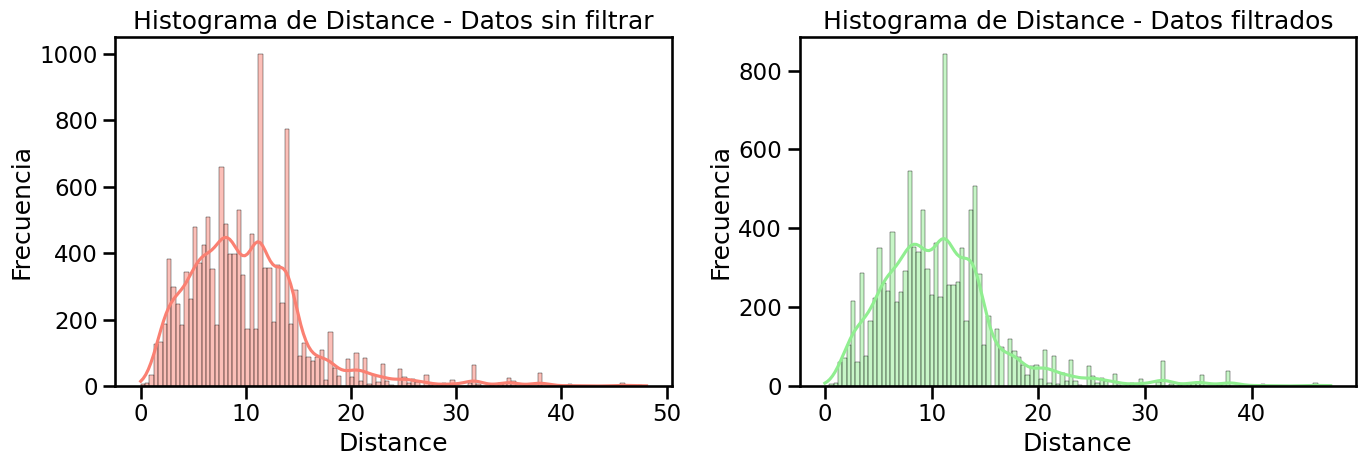

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


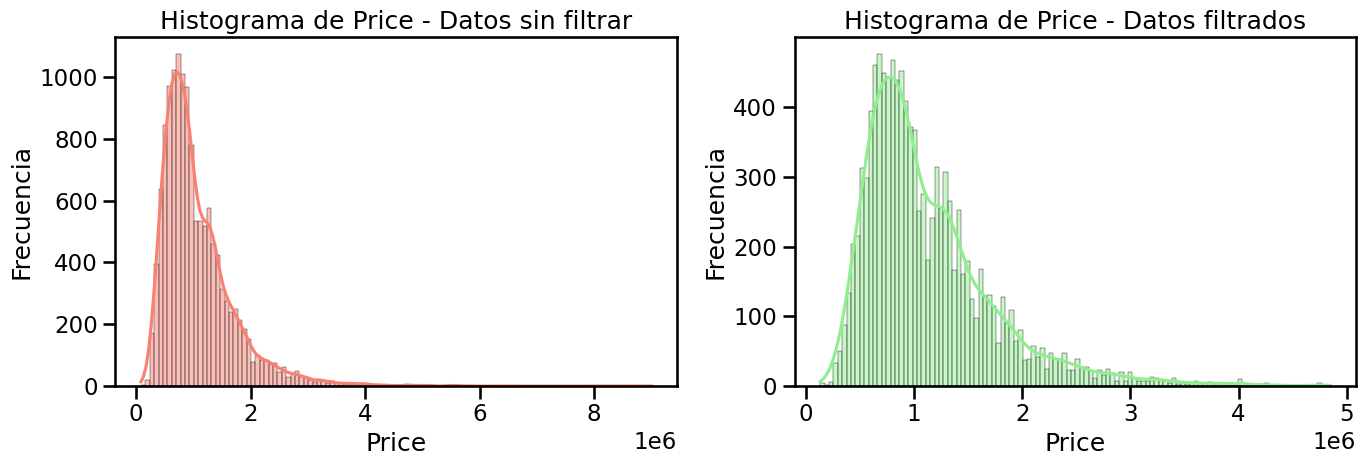

In [60]:
# Graficar continuas
for col in col_continuas:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histograma con datos originales
    sns.histplot(melb_pd_df[col], ax=axes[0], bins=int(math.sqrt(len(melb_pd_df))), kde=True, color='salmon')
    axes[0].set_title(f'Histograma de {col} - Datos sin filtrar')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frecuencia')
    
    # Histograma con datos filtrados
    sns.histplot(melb_filtered_11[col], ax=axes[1], bins=int(math.sqrt(len(melb_pd_df))), kde=True, color='lightgreen')
    axes[1].set_title(f'Histograma de {col} - Datos filtrados')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

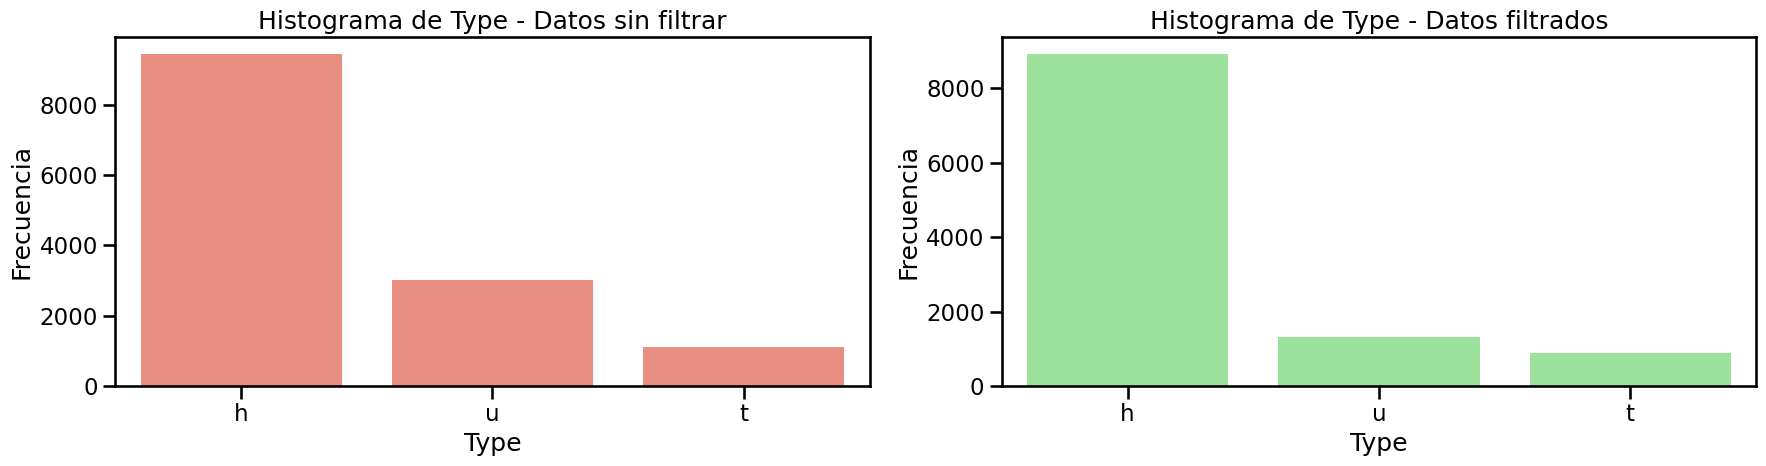

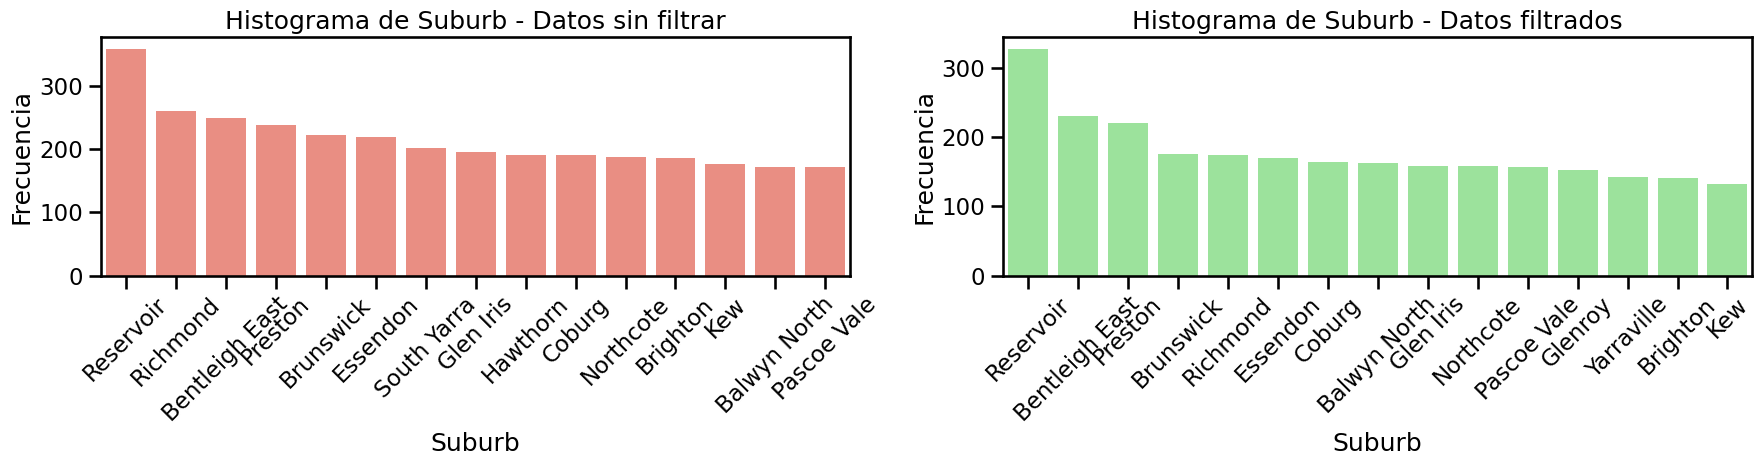

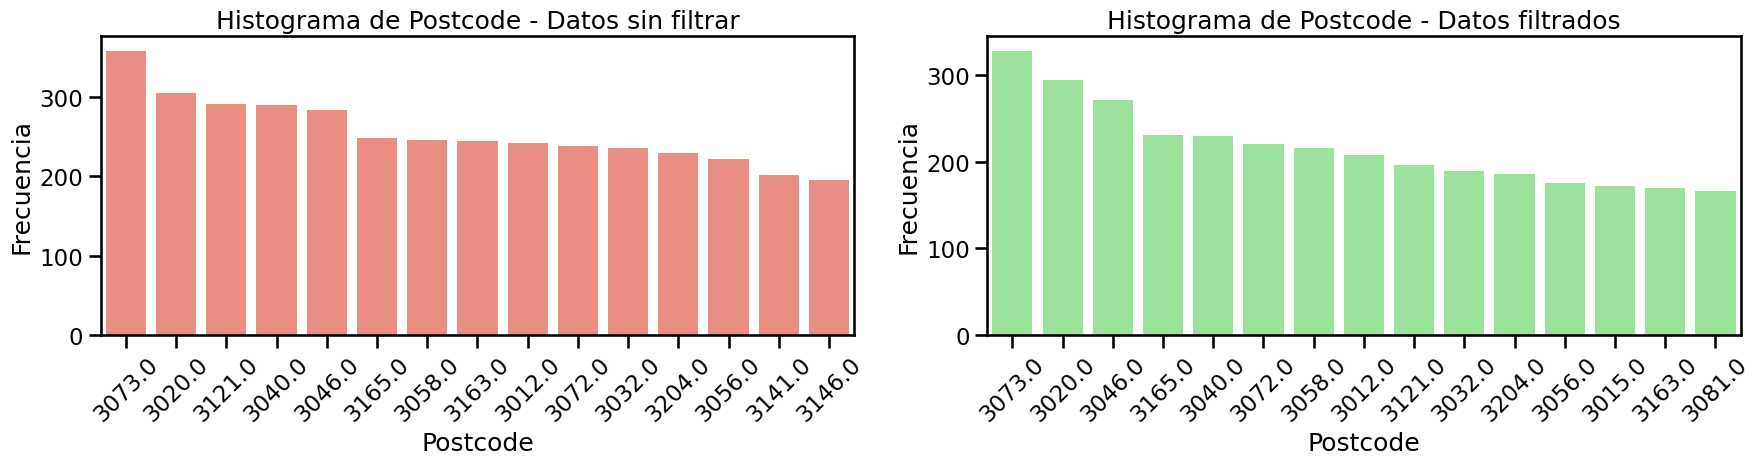

In [61]:
# Graficar discretas
for col in col_categoricas:
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    if col in ['Suburb', 'Postcode']:
        # Mostrar solo top 15 sin filtrar
        top_15_valores_sin_filtrar = melb_pd_df[col].value_counts().nlargest(15).index
        df_sin_filtrar = melb_pd_df[melb_pd_df[col].isin(top_15_valores_sin_filtrar)]
        # Mostrar solo tipo 15 filtrados
        top_15_filtrados = melb_filtered_11[col].value_counts().nlargest(15).index
        df_filtrado = melb_filtered_11[melb_filtered_11[col].isin(top_15_filtrados)]
        # Seteo cómo se verán las leyendas del eje x
        axes[0].tick_params(axis='x', rotation=45)
        axes[1].tick_params(axis='x', rotation=45)
    else:
        df_sin_filtrar = melb_pd_df
        df_filtrado = melb_filtered_11
    
    # Gráfico con datos originales
    sns.countplot(ax=axes[0], data=df_sin_filtrar, x=col, order=df_sin_filtrar[col].value_counts().index, color='salmon')
    axes[0].set_title(f'Histograma de {col} - Datos sin filtrar')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frecuencia')
    
    # Gráfico con datos filtrados
    sns.countplot(ax=axes[1], data=df_filtrado, x=col, order=df_filtrado[col].value_counts().index, color='lightgreen')
    axes[1].set_title(f'Histograma de {col} - Datos filtrados')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Frecuencia')
    
    plt.tight_layout()
    plt.show()

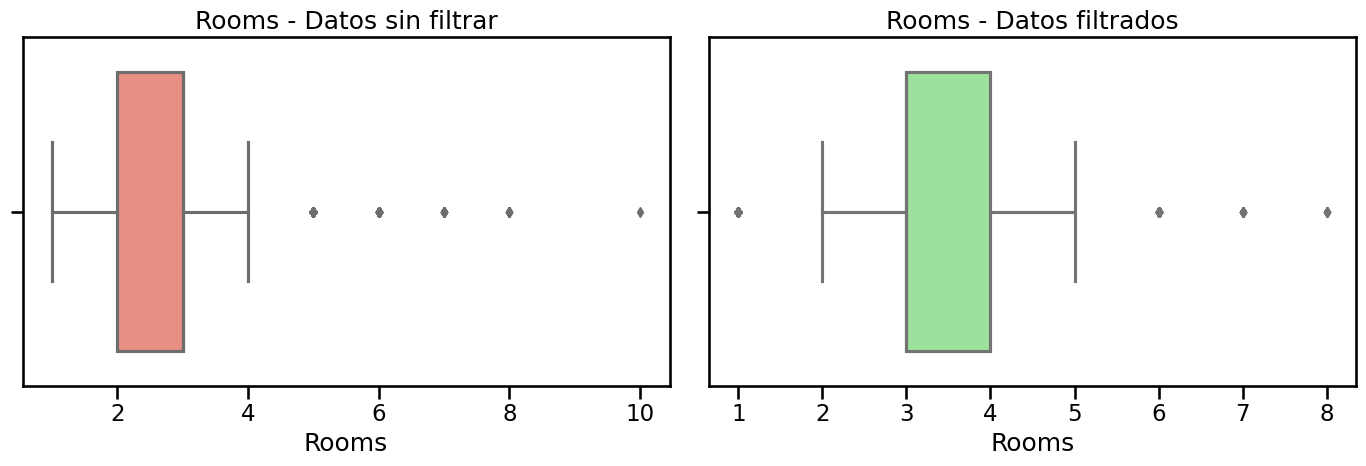

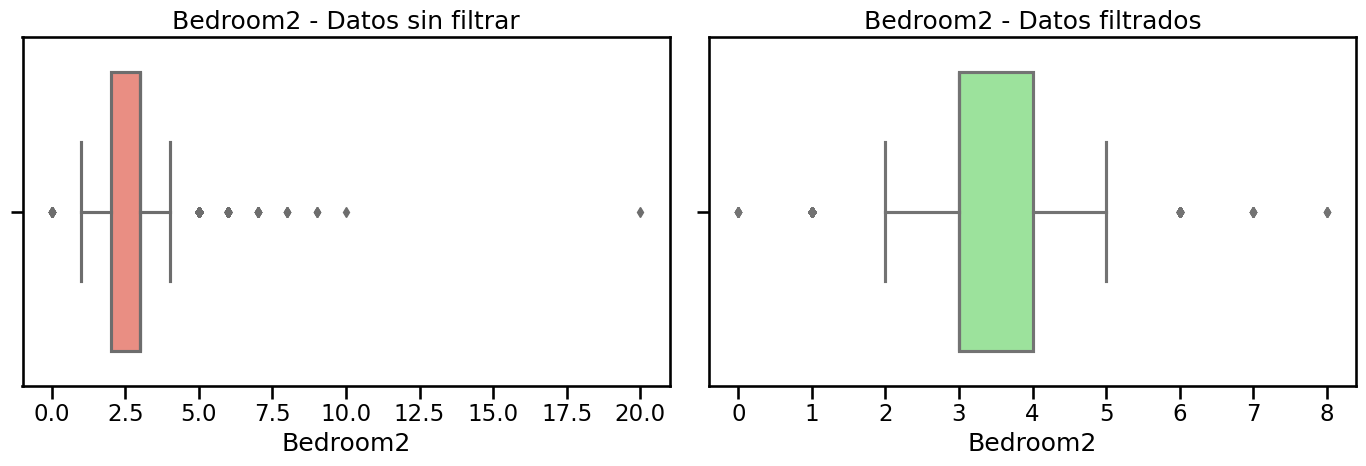

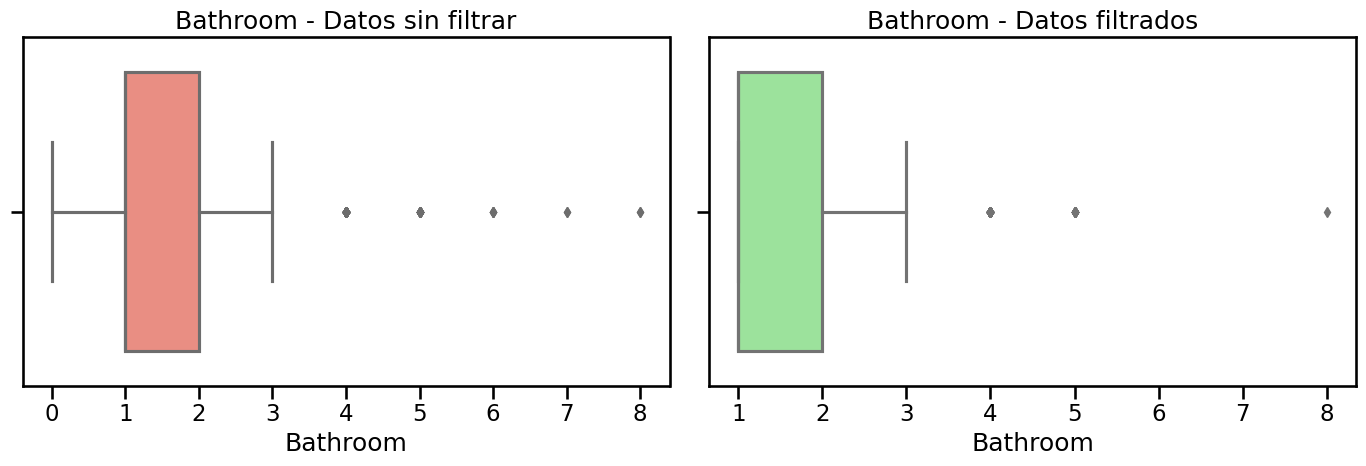

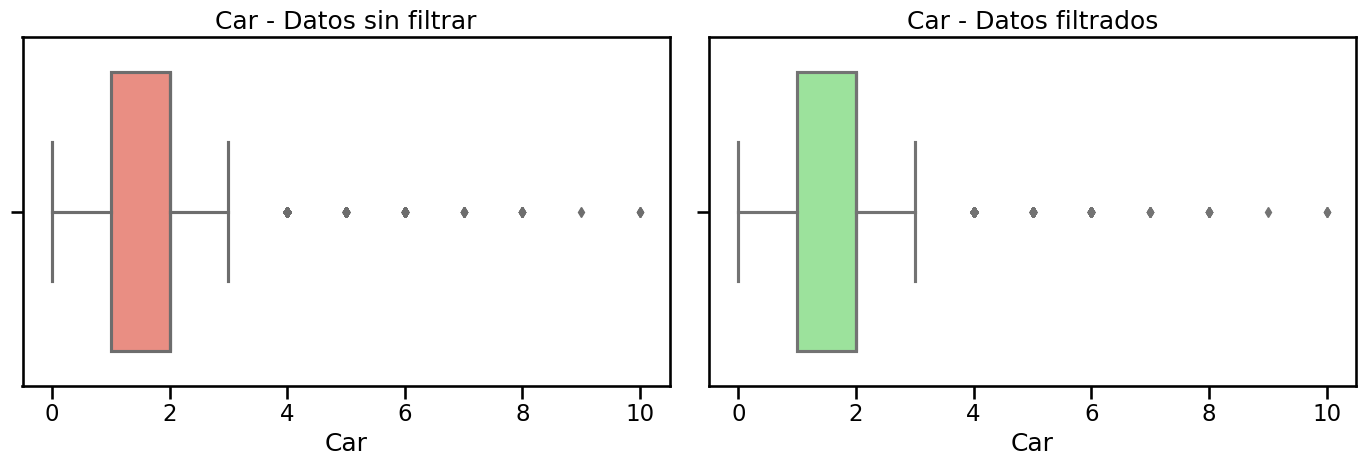

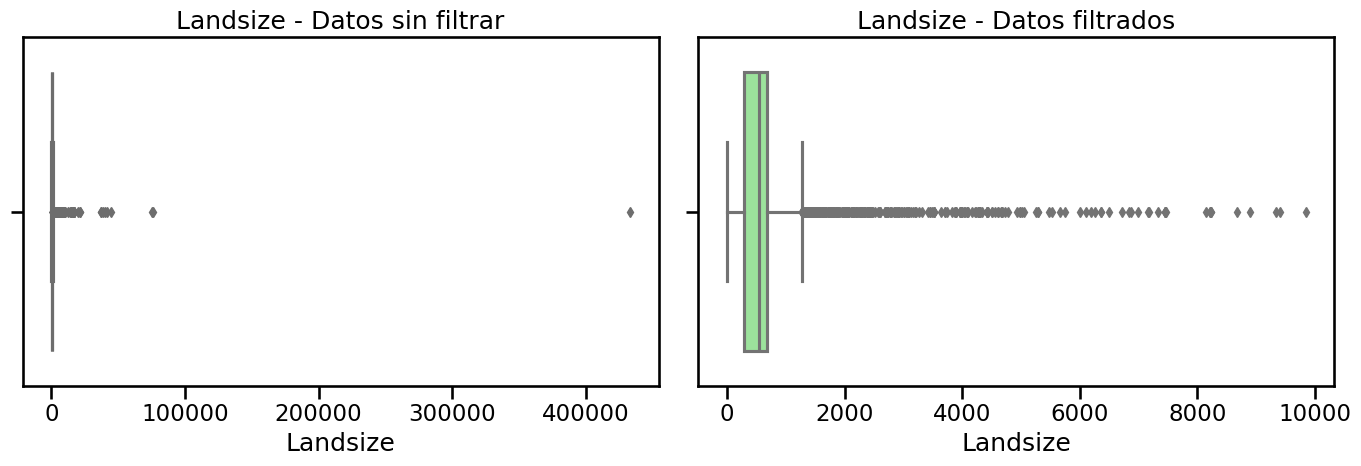

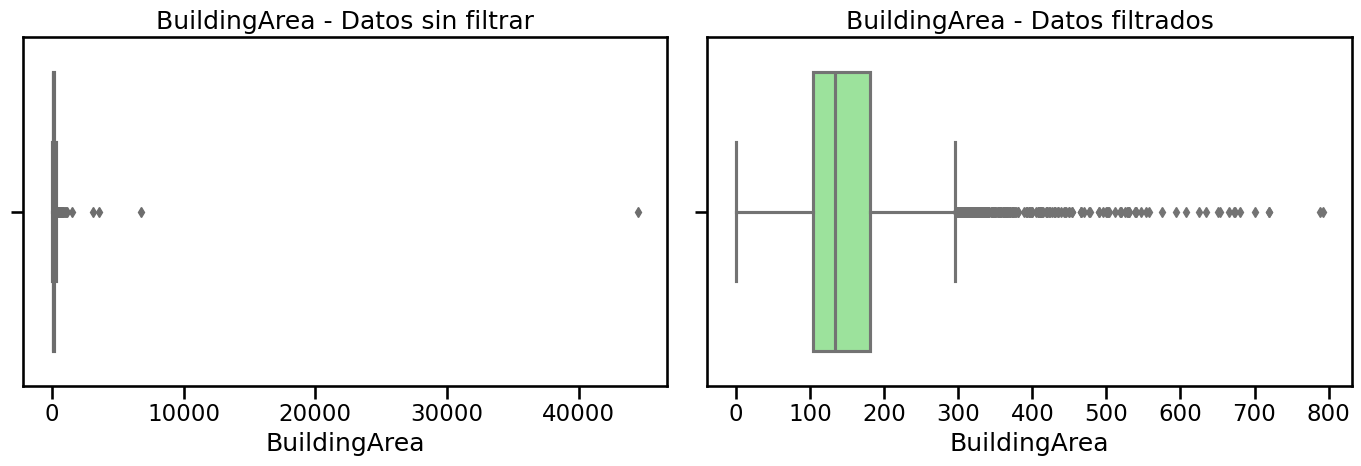

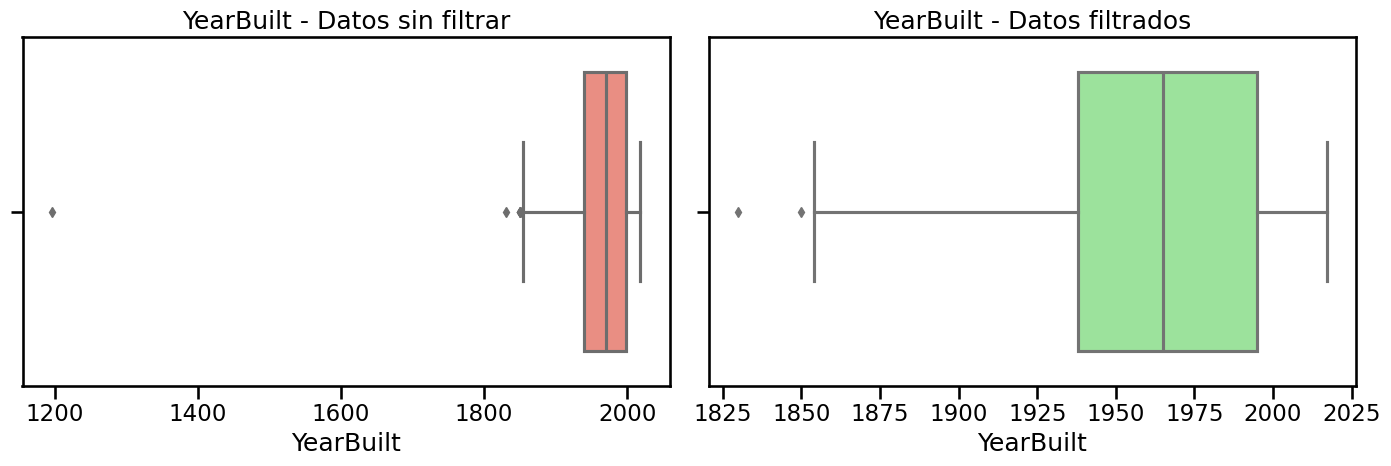

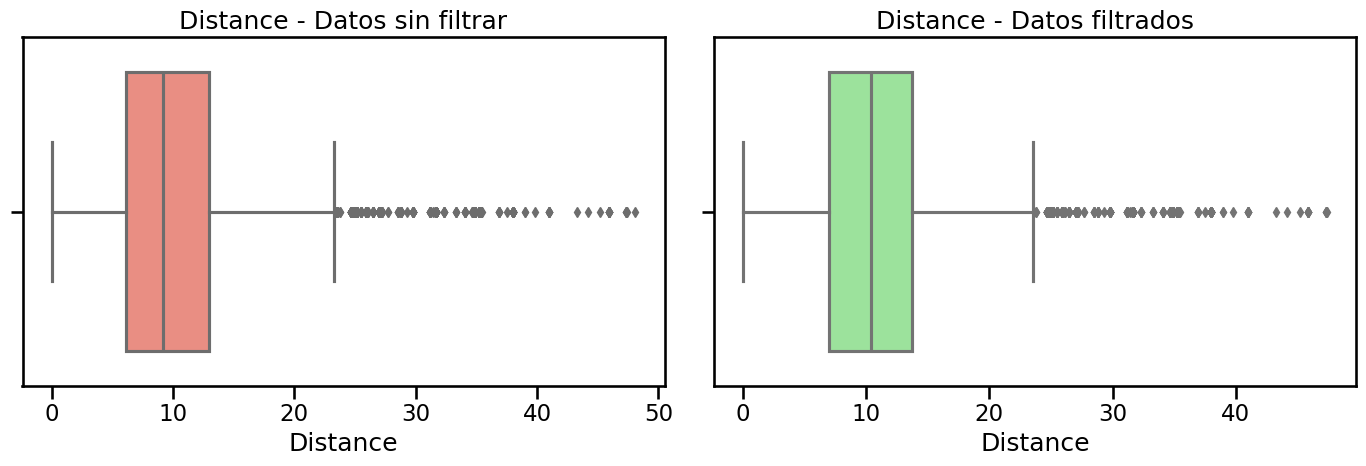

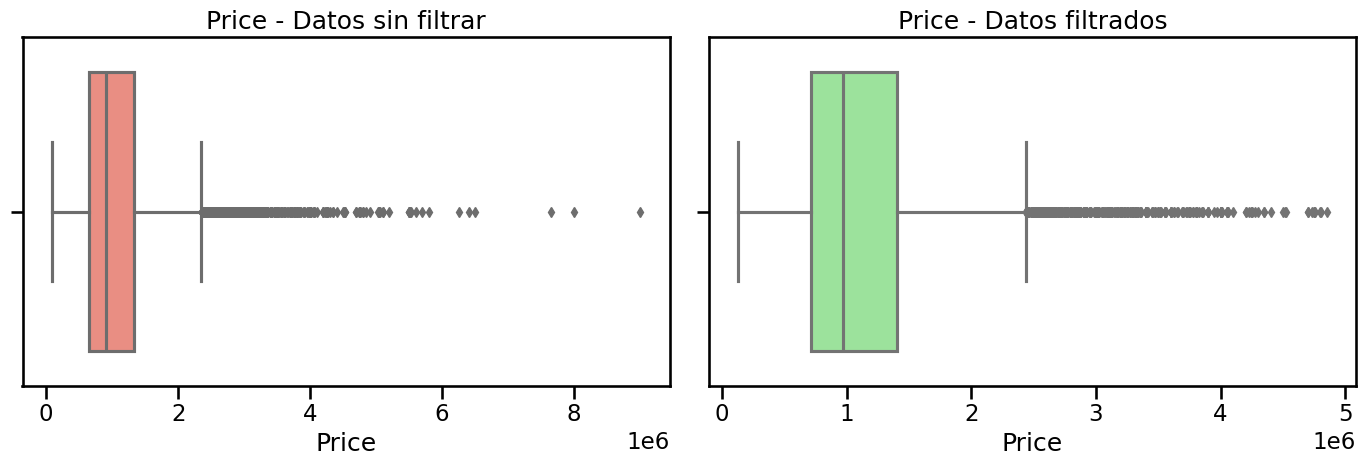

In [62]:
# Veamos los obxplot de las variables numérica, para los datasets original y filtrado
# Variables numéricas (discretas + continuas)
col_numericas = col_discretas + col_continuas

for col in col_numericas:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Sin filtrar
    sns.boxplot(ax=axes[0], data=melb_pd_df, x=col, color='salmon')
    axes[0].set_title(f'{col} - Datos sin filtrar')

    # Filtrado
    sns.boxplot(ax=axes[1], data=melb_filtered_11, x=col, color='lightgreen')
    axes[1].set_title(f'{col} - Datos filtrados')

    plt.tight_layout()
    plt.show()

Ahora para trabajar con el conjunto de datos de AirBnb con el que trabajamos en clase voy a importarlo:
```python

In [63]:
airbnb_clases = pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')

C:\Users\emman\AppData\Local\Temp\ipykernel_1192\2302217643.py:1: DtypeWarning: Columns (35,77) have mixed types. Specify dtype option on import or set low_memory=False.
  airbnb_clases = pd.read_csv('https://cs.famaf.unc.edu.ar/~mteruel/datasets/diplodatos/cleansed_listings_dec18.csv')


In [64]:
print(airbnb_clases.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'neighborhood_overview', 'notes', 'transit',
       'access', 'interaction', 'house_rules', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighborhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighborhood', 'city', 'suburb', 'state', 'zipcode',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 

De las columnsas existentes creemos que podemos sacar conclusiones interesantes del DataFrame 'airbnb_clases' con las siguientes columnas:
- **price**: Precio de la propiedad.
- **monthly_price**: Precio mensual de la propiedad.
- **weekly_price**: Precio semanal de la propiedad.
- **zipcode**: Código postal de la propiedad.

Vamos a averiguar si hay valores nulos en las columnas que elegimos para trabajar.
```python

In [65]:
interesting_columns = ['price', 'monthly_price', 'weekly_price', 'zipcode']

# Filtrar el DataFrame para incluir solo las columnas de interés
airbnb_clases = airbnb_clases[interesting_columns]

In [66]:
#Averiguamos si hay valores nulos en el dataframe
print(airbnb_clases.isnull().sum())
print('Total: ' + str(airbnb_clases.size))

price                0
monthly_price    21004
weekly_price     20371
zipcode            142
dtype: int64
Total: 91580


Eliminamos los las filas con valores nulos en 'zipcode':

In [ ]:
# Eliminamos las filas con zipcode nulos
airbnb_clases = airbnb_clases.dropna(subset=['zipcode'])
# Verificamos nuevamente si hay valores nulos
print(airbnb_clases.isnull().sum())
print('total: ' + str(airbnb_clases.size))

Vamos a crear un grafico de 'price' vs 'monthly_price' y de 'price' vs 'weekly_price' para ver si hay una correlación entre el precio de la propiedad y el precio mensual o semanal.
```python

Text(0, 0.5, 'Weekly Price')

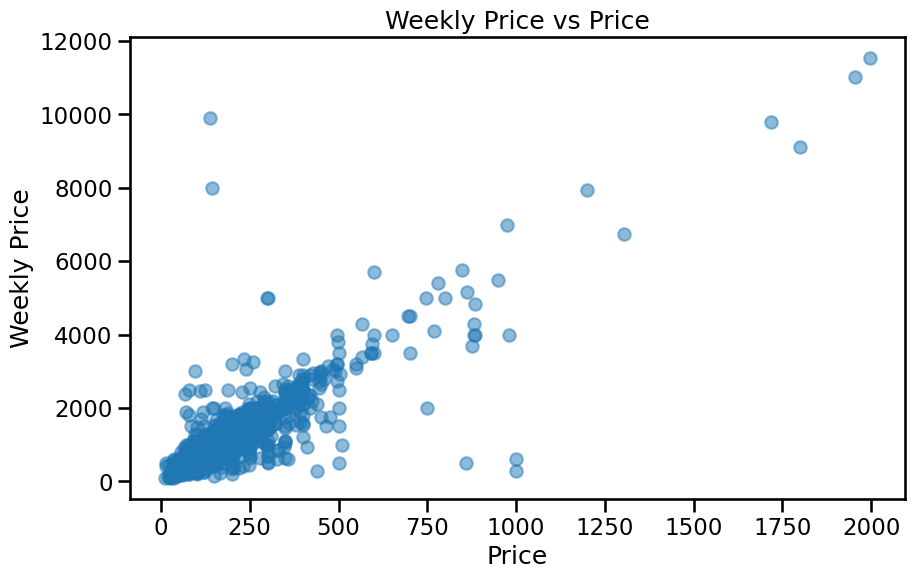

In [68]:
# Creamos un grafico de price vs weekly_price
plt.figure(figsize=(10, 6))
plt.scatter(airbnb_clases['price'], airbnb_clases['weekly_price'], alpha=0.5)
plt.title('Weekly Price vs Price')
plt.xlabel('Price')
plt.ylabel('Weekly Price')


Text(0, 0.5, 'Monthly Price')

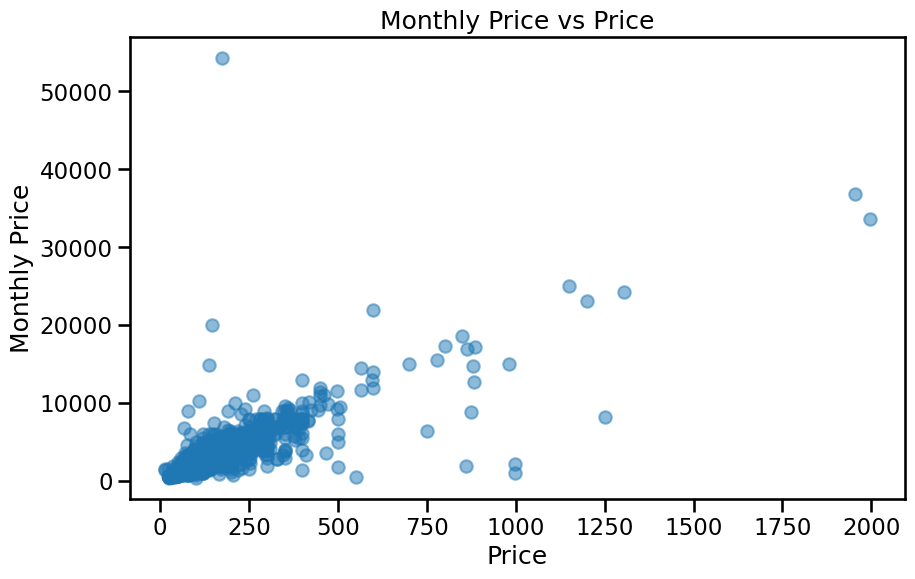

In [69]:
# Creamos un grafico de price vs weekly_price
plt.figure(figsize=(10, 6))
plt.scatter(airbnb_clases['price'], airbnb_clases['monthly_price'], alpha=0.5)
plt.title('Monthly Price vs Price')
plt.xlabel('Price')
plt.ylabel('Monthly Price')

Debido que a lo que podemos viualizar en el grafico de 'price' vs 'monthly_price' y de 'price' vs 'weekly_price' y que eliminando algunos valores podríamos obtener una relación lineal consideramos que es innecesario utilizar las 3 variables y que podríamos utilizar únicamente price.
```python

In [70]:
# Eliminamos las columnas monthly_price y weekly_price
airbnb_clases = airbnb_clases.drop(columns=['monthly_price', 'weekly_price'])
# Verificamos nuevamente si hay valores nulos
print(airbnb_clases.isnull().sum())
print('total: ' + str(airbnb_clases.size))

price      0
zipcode    0
dtype: int64
total: 45506


Vamos a contabilizar los valores de cada 'zipcode' para ver si hay alguno que tenga menos de 10 registros.
```python

In [71]:
# Contabilizamos los valores únicos de zipcode
print('Los valores unicos de zipcode son: ' + str(airbnb_clases['zipcode'].nunique()))
# Contamos la cantidad de registros por zipcode
print('Los registros por zipcode son:')
print(airbnb_clases['zipcode'].value_counts())

Los valores unicos de zipcode son: 463
Los registros por zipcode son:
zipcode
3000.0        2491
3000           876
3006.0         860
3182.0         579
3182           556
              ... 
3096             1
3812             1
3000\n3000       1
3752             1
4068.0           1
Name: count, Length: 463, dtype: int64


Como hay algunos 'zipcode' que no son enteros y pueden conducir a errores, vamos a convertirlos a enteros.
```python

In [72]:
# Eliminar filas donde zipcode no es un número válido
airbnb_clases = airbnb_clases[pd.to_numeric(airbnb_clases['zipcode'], errors='coerce').notnull()]
airbnb_clases['zipcode'] = airbnb_clases['zipcode'].astype(float).astype(int)

# Verificamos nuevamente los tipos de datos
print(airbnb_clases.dtypes)
# Verificamos nuevamente la cantidad de registros por zipcode
print('Los registros por zipcode son:')
print(airbnb_clases['zipcode'].value_counts())
print('Cantidad de zipcodes únicos:', airbnb_clases['zipcode'].nunique())

price      int64
zipcode    int32
dtype: object
Los registros por zipcode son:
zipcode
3000     3367
3006     1268
3182     1135
3141      881
3004      728
         ... 
3785        1
3096        1
30122       1
3912        1
4068        1
Name: count, Length: 247, dtype: int64
Cantidad de zipcodes únicos: 247


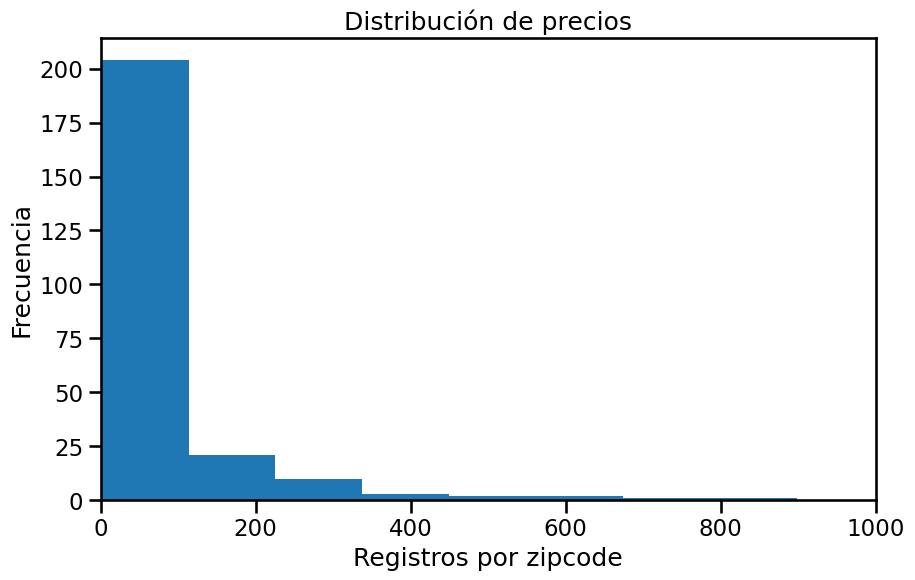

In [73]:
# Graficamos un histograma de la cantidad de registros por zipcode
plt.figure(figsize=(10, 6))
plt.hist(airbnb_clases['zipcode'].value_counts(), bins=30)
plt.title('Distribución de precios')
plt.xlabel('Registros por zipcode')
plt.ylabel('Frecuencia')
plt.xlim(0, 1000)  # Limita el eje x de 0 a 1000
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='count', ylabel='Count'>

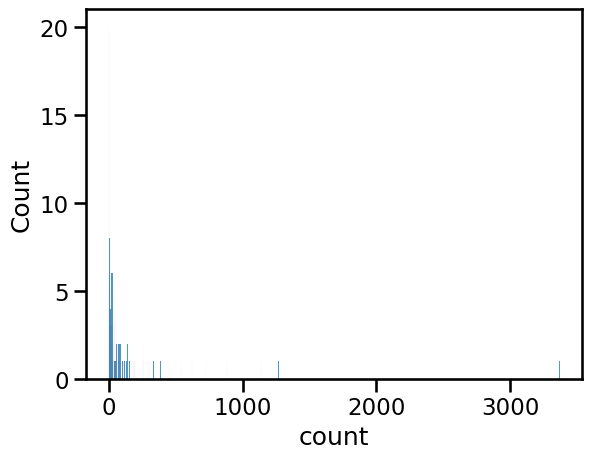

In [74]:
sns.histplot(airbnb_clases['zipcode'].value_counts(), bins=airbnb_clases['zipcode'].value_counts().nunique(), discrete=True, kde=False)

In [75]:
ocurrZipcode = airbnb_clases['zipcode'].value_counts()

minOcurr = 50

conteos_pc = airbnb_clases['zipcode'].value_counts()
conteos_pc = [num for num in conteos_pc if num >= minOcurr]
conteos_pc = sorted(conteos_pc, reverse=True)
for num in conteos_pc:
    print(num)
print('Total de zipcodes con un registro mayor o igual a ' + str(minOcurr) + ': ' + str(len(conteos_pc)))

3367
1268
1135
881
728
628
616
538
460
446
387
338
335
326
308
300
297
284
267
258
258
257
214
198
197
189
188
187
185
184
176
156
152
141
141
138
133
124
122
122
118
116
114
113
107
106
104
103
90
89
89
88
87
87
82
81
81
80
77
76
74
74
72
72
71
71
70
69
68
68
65
61
60
60
59
59
57
56
56
53
53
52
51
50
Total de zipcodes con un registro mayor o igual a 50: 84


Para que la media y la desviación estándar de 'price' por 'zipcode' tengan algun sentido estadístico decidimos establecer un piso mínimo de 50 registros por 'zipcode'.
```python

Procedemos a eliminar los 'zipcode' que no cumplen con el piso mínimo de 50 registros:
```python

In [76]:
# Elimino de airbnb_clases los zipcodes que tienen menos de 50 registros
conteos = airbnb_clases['zipcode'].value_counts()
zipcodes_validos = conteos[conteos >= minOcurr].index
airbnb_clases = airbnb_clases[airbnb_clases['zipcode'].isin(zipcodes_validos)]
# Verificamos nuevamente si hay valores nulos
print(airbnb_clases.isnull().sum())
print('total: ' + str(airbnb_clases.size))
# Verificamos nuevamente la cantidad de registros por zipcode
print('Los registros por zipcode son:')
print(airbnb_clases['zipcode'].value_counts())

price      0
zipcode    0
dtype: int64
total: 40036
Los registros por zipcode son:
zipcode
3000    3367
3006    1268
3182    1135
3141     881
3004     728
        ... 
3187      53
3109      53
3039      52
3165      51
3191      50
Name: count, Length: 84, dtype: int64


Vamos a crear una columna nueva en el DataFrame 'melb_pd_df' que contenga la mediana de los precios de las propiedades por 'zipcode' del DataFrame 'airbnb_clases' y otra su desviación standard.
```python

In [77]:
# Necesito imprimir el precio por zipcode
print(airbnb_clases[['zipcode', 'price']].head())

# Calcular la media del precio por zipcode en airbnb_clases
media_por_zipcode = airbnb_clases.groupby('zipcode')['price'].mean().reset_index()
# Renombrar la columna de media para mayor claridad
media_por_zipcode.columns = ['zipcode', 'media_price']

# Calcular la mediana del precio por zipcode en airbnb_clases
mediana_por_zipcode = airbnb_clases.groupby('zipcode')['price'].median().reset_index()

# Calcular la desviación estándar del precio por zipcode en airbnb_clases
desviacion_por_zipcode = airbnb_clases.groupby('zipcode')['price'].std().reset_index()
mediana_por_zipcode.columns = ['zipcode', 'mediana_price']
desviacion_por_zipcode.columns = ['zipcode', 'desviacion_price']
# Unir los resultados de mediana, desviación estándar y media en un solo DataFrame
resultados_zipcode = pd.merge(media_por_zipcode, mediana_por_zipcode, on='zipcode')
resultados_zipcode = pd.merge(resultados_zipcode, desviacion_por_zipcode, on='zipcode')
# Mostrar los resultados
print(resultados_zipcode.head())


   zipcode  price
1     3057     35
2     3182    159
3     3071     50
4     3183     69
6     3073     50
   zipcode  media_price  mediana_price  desviacion_price
0     3000   150.504307          129.0        189.529766
1     3002   200.979695          130.0        220.503204
2     3003   130.205993          120.0         77.007803
3     3004   158.271978          130.0        131.771854
4     3006   188.851735          150.0        196.919689


In [78]:
#Total de registros en resultados_zipcode
total_registros = len(resultados_zipcode)
print(f'Total de registros en resultados_zipcode: {total_registros}')

Total de registros en resultados_zipcode: 84


Debido a que se observa que la desviacion estándar parece alta vamos a contabilizar la cantidad de zipcodes que tengan una desviacion estandar mayor a la media.
```python

In [79]:
# Total de registros que tienen una desviación estándar mayor que su media
total_desviacion_mayor_media = len(resultados_zipcode[resultados_zipcode['desviacion_price'] > resultados_zipcode['media_price']])
print(f'Total de registros con desviación estándar mayor que la media: {total_desviacion_mayor_media}')
print(f'Porcentaje de registros con desviación estándar mayor que la media: {total_desviacion_mayor_media / total_registros * 100:.2f}%')

Total de registros con desviación estándar mayor que la media: 25
Porcentaje de registros con desviación estándar mayor que la media: 29.76%


Debido a que aproximadamente el 30% de los zipcodes tienen una desviación estándar mayor a la media, consideramos que es un valor alto vamos a utilizar la mediana al momento de unir los dataframes como datos relevantes.
Vamos a unir los dataframes 'melb_pd_df' y 'airbnb_clases' por 'zipcode' para agregar la mediana de los precios de las propiedades por 'zipcode' del DataFrame 'airbnb_clases'.
```python

In [80]:
# Creo un dataframe con la columna zipcode y la mediana del precio
mediana_zipcode = resultados_zipcode[['zipcode', 'mediana_price']].copy()
# Renombro la columna de mediana para mayor claridad
mediana_zipcode.columns = ['zipcode', 'mediana_price']
# Verifico los tipos de datos
print(mediana_zipcode.dtypes)
# Verifico si hay valores nulos
print(mediana_zipcode.isnull().sum())
# Verifico la cantidad de registros por zipcode
print('Los registros por zipcode son:')
print(mediana_zipcode['zipcode'].value_counts())

zipcode            int32
mediana_price    float64
dtype: object
zipcode          0
mediana_price    0
dtype: int64
Los registros por zipcode son:
zipcode
3000    1
3143    1
3165    1
3163    1
3162    1
       ..
3065    1
3058    1
3057    1
3056    1
3799    1
Name: count, Length: 84, dtype: int64


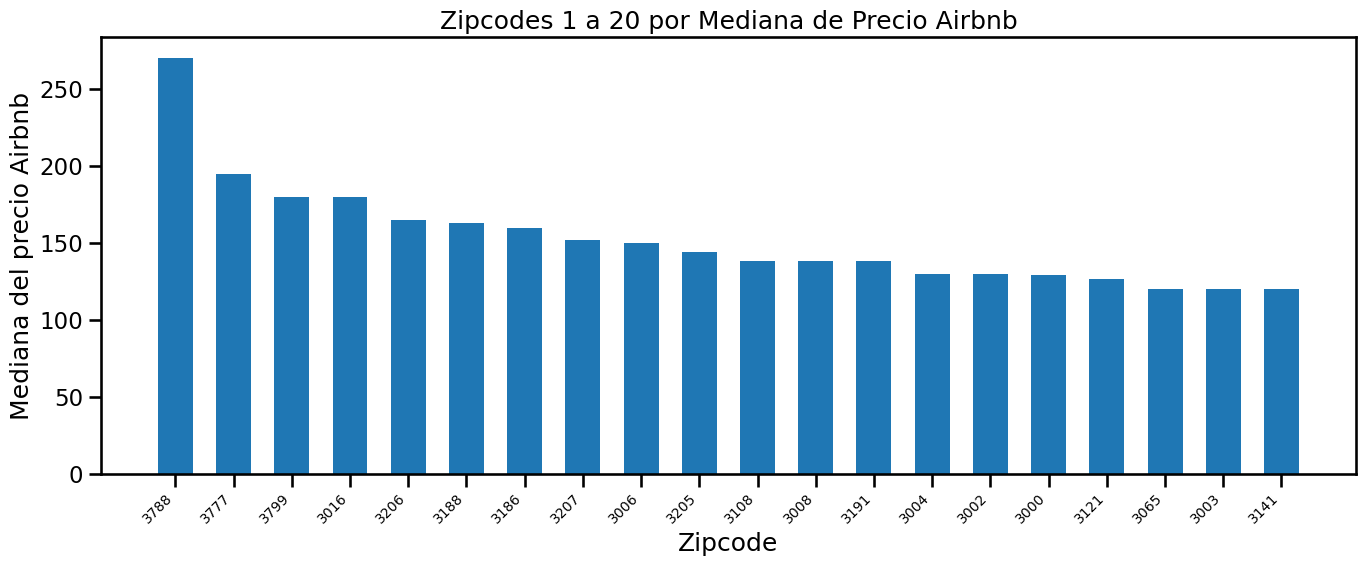

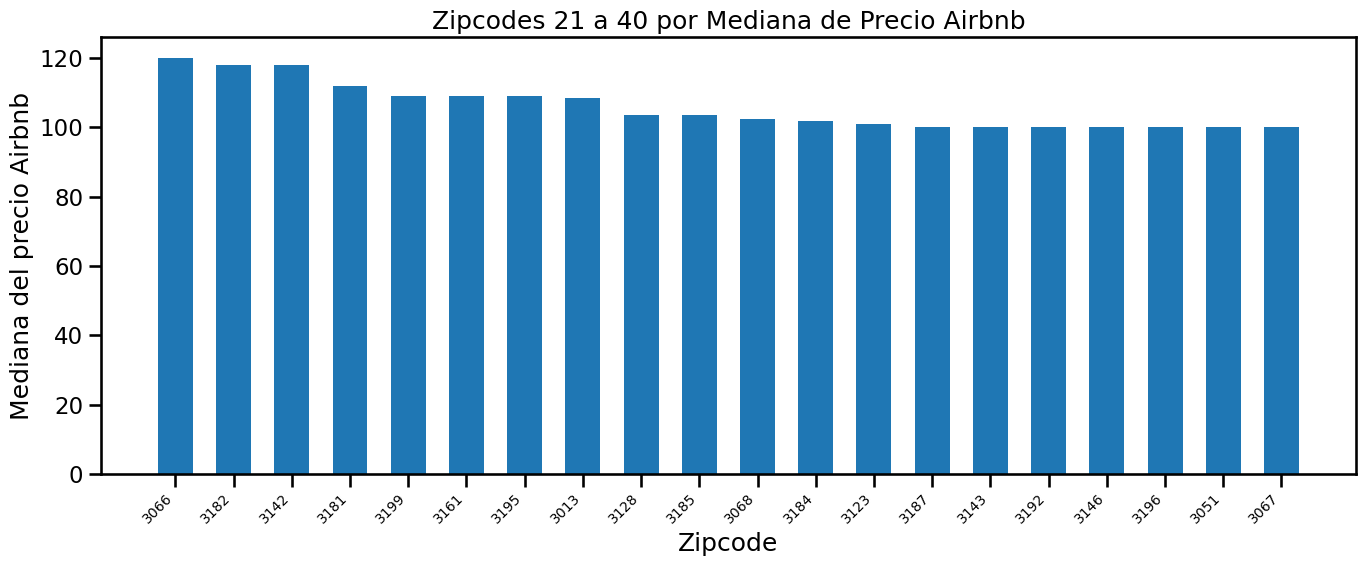

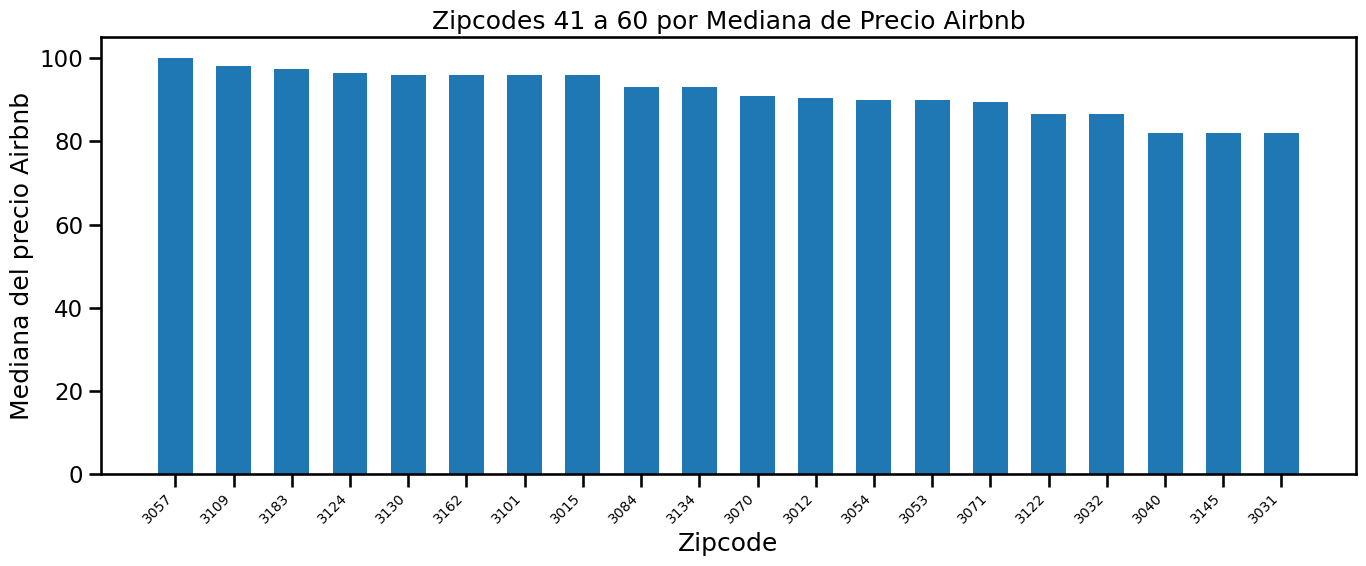

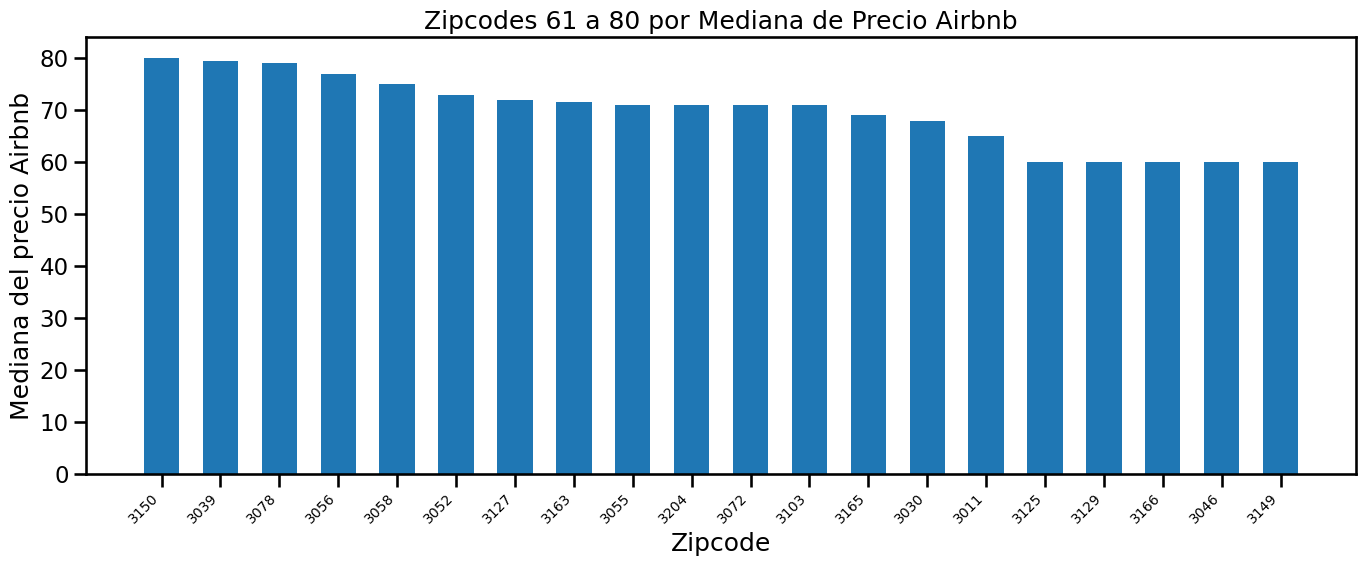

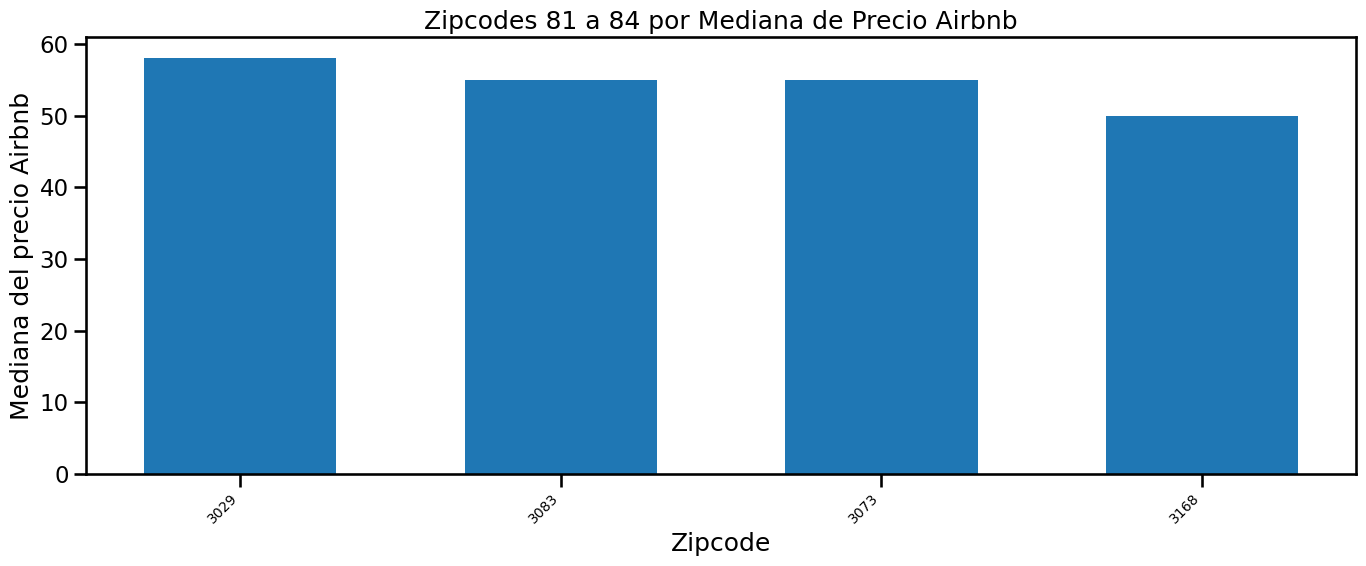

In [81]:
import math

zipcodes_sorted = mediana_zipcode.sort_values('mediana_price', ascending=False).reset_index(drop=True)
n = 20  # cantidad de zipcodes por gráfico
total = len(zipcodes_sorted)
num_plots = math.ceil(total / n)

for i in range(num_plots):
    start = i * n
    end = start + n
    subset = zipcodes_sorted.iloc[start:end]
    plt.figure(figsize=(14,6))
    plt.bar(subset['zipcode'].astype(str), subset['mediana_price'], width=0.6)
    plt.xlabel('Zipcode')
    plt.ylabel('Mediana del precio Airbnb')
    plt.title(f'Zipcodes {start+1} a {min(end, total)} por Mediana de Precio Airbnb')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.show()

Revisamos las columnas del DataFrame 'df_filtrado' y el total de registros:
```python

In [84]:
# Columnas de df_filtrado
print("Columnas de df_filtrado:")
print(df_filtrado.columns)
print("\n")
print("Total de registros en df_filtrado:", len(df_filtrado))

# Columnas de zipcodes_sorted
print("Columnas de zipcodes_sorted:")
print(zipcodes_sorted.columns)
print("\n")
print("Total de registros en zipcodes_sorted:", len(zipcodes_sorted))
# Verificamos si hay valores nulos en zipcodes_sorted

Columnas de df_filtrado:
Index(['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'YearBuilt', 'Distance', 'Type', 'Price', 'Suburb', 'Postcode'],
      dtype='object')


Total de registros en df_filtrado: 3251
Columnas de zipcodes_sorted:
Index(['zipcode', 'mediana_price'], dtype='object')


Total de registros en zipcodes_sorted: 84


Revisamos si existen registros de 'df_filtrado' que no tengan 'Postcode':
```python

In [85]:
# Total de regisstros con 'Postcode' nulo en df_filtrado
print("Total de registros con 'Postcode' nulo en df_filtrado:", df_filtrado['Postcode'].isnull().sum())

Total de registros con 'Postcode' nulo en df_filtrado: 0


Transformamos todos los valores de 'Postcode' a enteros para evitar errores al momento de guardar el DataFrame en la base de datos:
```python

In [86]:
# Tranformamos 'Postcode' a entero en df_filtrado
df_filtrado['Postcode'] = df_filtrado['Postcode'].astype(int)
# Verificamos nuevamente los tipos de datos
print("Tipos de datos en df_filtrado después de la transformación:")
print(df_filtrado.dtypes)
# Verificamos si hay valores nulos en df_filtrado
print("Total de registros con 'Postcode' nulo en df_filtrado después de la transformación:", df_filtrado['Postcode'].isnull().sum())
# Mostramos los primeros registros de df_filtrado
print("Primeros registros de df_filtrado:")
print(df_filtrado.head())

Tipos de datos en df_filtrado después de la transformación:
Rooms             int64
Bedroom2        float64
Bathroom        float64
Car             float64
Landsize        float64
BuildingArea    float64
YearBuilt       float64
Distance        float64
Type             object
Price           float64
Suburb           object
Postcode          int32
dtype: object
Total de registros con 'Postcode' nulo en df_filtrado después de la transformación: 0
Primeros registros de df_filtrado:
     Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
284      3       3.0       1.0  2.0     298.0         108.0     1920.0   
286      3       3.0       2.0  2.0     277.0         174.0     1910.0   
287      2       2.0       1.0  1.0     423.0          62.0     1970.0   
288      4       4.0       3.0  1.0     478.0         270.0     1900.0   
289      3       3.0       1.0  2.0     623.0           NaN     1938.0   

     Distance Type      Price      Suburb  Postcode  
284       5.9    h

C:\Users\emman\AppData\Local\Temp\ipykernel_1192\3187000904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Postcode'] = df_filtrado['Postcode'].astype(int)


Realizamos la union propiamente dicha:
```python

In [87]:
df_filtrado['Postcode'] = df_filtrado['Postcode'].astype(int)
mediana_zipcode['zipcode'] = mediana_zipcode['zipcode'].astype(int)

# Realiza el merge
df_unido = df_filtrado.merge(
    mediana_zipcode[['zipcode', 'mediana_price']],
    left_on='Postcode',
    right_on='zipcode',
    how='left'
)

# Ahora df_unido tiene una columna 'mediana_price' correspondiente a cada Postcode
print(df_unido.head())

   Rooms  Bedroom2  Bathroom  Car  Landsize  BuildingArea  YearBuilt  \
0      3       3.0       1.0  2.0     298.0         108.0     1920.0   
1      3       3.0       2.0  2.0     277.0         174.0     1910.0   
2      2       2.0       1.0  1.0     423.0          62.0     1970.0   
3      4       4.0       3.0  1.0     478.0         270.0     1900.0   
4      3       3.0       1.0  2.0     623.0           NaN     1938.0   

   Distance Type      Price      Suburb  Postcode  zipcode  mediana_price  
0       5.9    h   940000.0  Ascot Vale      3032   3032.0           86.5  
1       5.9    h  1380000.0  Ascot Vale      3032   3032.0           86.5  
2       5.9    u   490000.0  Ascot Vale      3032   3032.0           86.5  
3       5.9    h  1850000.0  Ascot Vale      3032   3032.0           86.5  
4       5.9    h  1284000.0  Ascot Vale      3032   3032.0           86.5  


C:\Users\emman\AppData\Local\Temp\ipykernel_1192\2878548864.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['Postcode'] = df_filtrado['Postcode'].astype(int)


In [89]:
print(df_unido.columns)

Index(['Rooms', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea',
       'YearBuilt', 'Distance', 'Type', 'Price', 'Suburb', 'Postcode',
       'zipcode', 'mediana_price'],
      dtype='object')


Revisamos la cantidad de registros de 'df_unido' y si existen registros que no tengan mediana de precios por 'zipcode':
```python

In [91]:
# Imprimimos la cantidad de registros en df_unido
print("Total de registros en df_unido:", len(df_unido))
# Verificamos si hay valores NaN en 'mediana_price'
print("Total de registros con 'mediana_price' nulo en df_unido:", df_unido['mediana_price'].isnull().sum())
# Mostramos el porcentaje de registros con 'mediana_price' nulo:
print("Porcentaje de registros con 'mediana_price' nulo en df_unido:", 
      df_unido['mediana_price'].isnull().sum() / len(df_unido) * 100)

Total de registros en df_unido: 3251
Total de registros con 'mediana_price' nulo en df_unido: 460
Porcentaje de registros con 'mediana_price' nulo en df_unido: 14.149492463857275


Discutimos en grupo que dos variables adicionales podrían ser útiles para combinar los datos podrían ser la distancia a puntos de interés o turísticos de la ciudad (que podrían diferir de la distancia al centro) y el IDH del suburbio o zipcode, ya que podría ser un indicador del nivel socioeconómico de la zona y, por ende, del valor de las propiedades.
Si las coordenadas geoespaciales estuvieran disponibles, podríamos utilizarlas para calcular distancias a puntos de interés, como centros comerciales, escuelas, hospitales, parques, etc. Esto nos permitiría enriquecer aún más el conjunto de datos y potencialmente mejorar la precisión de los modelos predictivos al considerar la proximidad a estos servicios.
También podríamos cuadricular el área geográfica y calcular la densidad de propiedades por unidad de área, lo que podría ser un indicador de la oferta y demanda en diferentes zonas de Melbourne o calcular el precio pr cuadrícula.

Otra opción a utilizar las coordenadas geoespaciales que se nos ocurrió sería dividir la ciudad en cuadrantes y calcular la media o mediana de los precios de las propiedades por cuadrante. Por lo general en las ciudades los precios de suelen aumentar al norte, pero como Melbourne tiene la playa al sur, esto podría no ser cierto. Por lo que sería interesante ver si se cumple esta tendencia en esta ciudad.
```python

## Ejercicio 3:

Crear y guardar un nuevo conjunto de datos con todas las transformaciones realizadas anteriormente.

In [93]:
# Guardamos el DataFrame resultante en un archivo CSV
df_unido.to_csv('airbnb_unido.csv', index=False)

## Ejercicios opcionales:

1. Armar un script en python (archivo .py) [ETL](https://towardsdatascience.com/what-to-log-from-python-etl-pipelines-9e0cfe29950e) que corra los pasos de extraccion, transformacion y carga, armando una funcion para cada etapa del proceso y luego un main que corra todos los pasos requeridos.

2. Armar un DAG en Apache Airflow que corra el ETL. (https://airflow.apache.org/docs/apache-airflow/stable/tutorial.html)